<a href="https://colab.research.google.com/github/SebaAyala/AST_TP_2/blob/main/AST_TP_2_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerias

In [ ]:
! pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [ ]:
!git clone https://github.com/google-research/timesfm.git

In [ ]:
!pip install -e ./timesfm -q

In [ ]:
%pip install optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

from google.colab import drive
from google.colab import auth
from google.auth import default


import torch
from chronos import ChronosPipeline

from sklearn.preprocessing import StandardScaler

import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
creds, _ = default()
drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

Mounted at /content/drive


## Carga de datasets

In [3]:
# Ruta al archivo en tu Google Drive
df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
df_precipitaciones = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/precip.xlsx', skiprows=3)
df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])

/tmp/ipython-input-633792332.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
/tmp/ipython-input-633792332.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])


In [4]:
print(df_siniestros.head())
print(df_precipitaciones.head())
print(df_temperatura.head())

          id_hecho  n_victimas       fecha  aaaa  mm  dd      hora  hh  \
0  LC-2019-0008283           2  2019-01-04  2019   1   4  17:53:00  17   
1  LC-2019-0007634           1  2019-01-04  2019   1   4  14:50:00  14   
2  LC-2019-0008974           1  2019-01-05  2019   1   5  09:30:00   9   
3  LC-2019-0010983           2  2019-01-06  2019   1   6  22:20:00  22   
4  LC-2019-0011092           1  2019-01-07  2019   1   7  03:50:00   3   

  direccion_normalizada calle  ... comuna tipo_de_calle geocodificacion_caba  \
0                    SD   NaN  ...     SD            SD                   SD   
1                    SD   NaN  ...     SD            SD                   SD   
2                    SD   NaN  ...     SD            SD                   SD   
3                    SD   NaN  ...     SD            SD                   SD   
4                    SD   NaN  ...     SD            SD                   SD   

  longitud latitud participantes    victima contraparte gravedad tipo_de_d

In [5]:
lista_datasets = [df_siniestros, df_precipitaciones, df_temperatura]
for i in lista_datasets:
  print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44012 entries, 0 to 44011
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_hecho               44012 non-null  object
 1   n_victimas             44012 non-null  int64 
 2   fecha                  44012 non-null  object
 3   aaaa                   44012 non-null  int64 
 4   mm                     44012 non-null  int64 
 5   dd                     44012 non-null  int64 
 6   hora                   44012 non-null  object
 7   hh                     44012 non-null  object
 8   direccion_normalizada  44012 non-null  object
 9   calle                  33111 non-null  object
 10  altura                 32665 non-null  object
 11  cruce                  29509 non-null  object
 12  otra_direccion         44012 non-null  object
 13  comuna                 44012 non-null  object
 14  tipo_de_calle          44012 non-null  object
 15  geocodificacion_cab

# Siniestros

In [6]:
df_siniestros['fecha'] = pd.to_datetime(df_siniestros['fecha'],  errors='coerce')
df_siniestros.head()

id_hecho  n_victimas      fecha  aaaa  mm  dd      hora  hh  \
0  LC-2019-0008283           2 2019-01-04  2019   1   4  17:53:00  17   
1  LC-2019-0007634           1 2019-01-04  2019   1   4  14:50:00  14   
2  LC-2019-0008974           1 2019-01-05  2019   1   5  09:30:00   9   
3  LC-2019-0010983           2 2019-01-06  2019   1   6  22:20:00  22   
4  LC-2019-0011092           1 2019-01-07  2019   1   7  03:50:00   3   

  direccion_normalizada calle  ... comuna tipo_de_calle geocodificacion_caba  \
0                    SD   NaN  ...     SD            SD                   SD   
1                    SD   NaN  ...     SD            SD                   SD   
2                    SD   NaN  ...     SD            SD                   SD   
3                    SD   NaN  ...     SD            SD                   SD   
4                    SD   NaN  ...     SD            SD                   SD   

  longitud latitud participantes    victima contraparte gravedad tipo_de_dato  
0       SD      SD       AUTO-SD       AUTO          SD       SD   definitivo  
1       SD      SD       MOTO-SD       MOTO          SD       SD   definitivo  
2       SD      SD  BICICLETA-SD  BICICLETA          SD       SD   definitivo  
3       SD      SD       AUTO-SD       AUTO          SD       SD   definitivo  
4       SD      SD     PEATON-SD     PEATON          SD       SD   definitivo  

[5 rows x 23 columns]

In [7]:
df_siniestros = df_siniestros.groupby('fecha').size().reset_index(name='cantidad_eventos')
# df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

fecha  cantidad_eventos
0 2019-01-01                18
1 2019-01-02                16
2 2019-01-03                24
3 2019-01-04                35
4 2019-01-05                19

In [8]:
df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

cantidad_eventos
fecha                       
2019-01-01                18
2019-01-02                16
2019-01-03                24
2019-01-04                35
2019-01-05                19

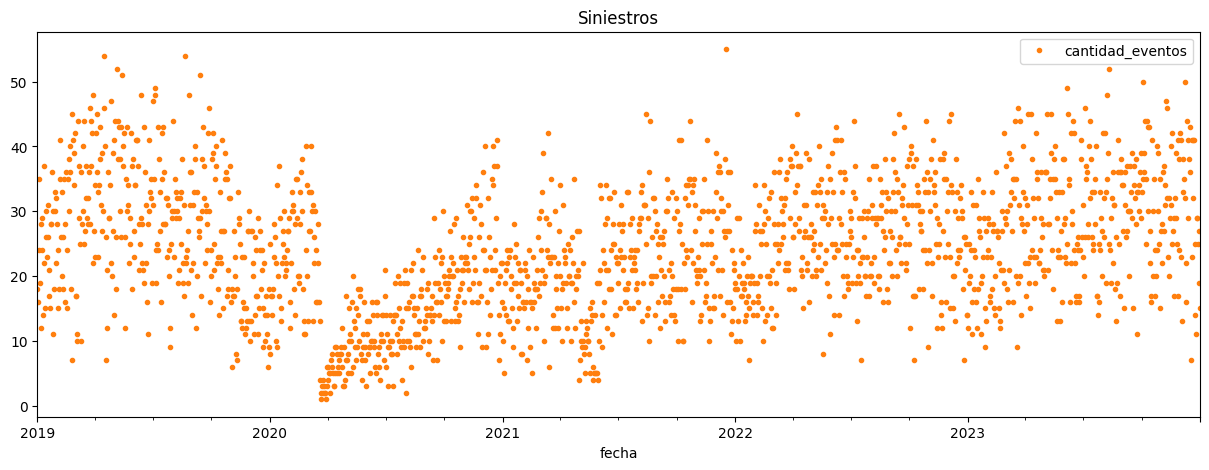

In [9]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

In [10]:
print('Cantidad de NaNs:')
for column in df_siniestros:
    nans = df_siniestros[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna cantidad_eventos: 0


Analisis de outliers

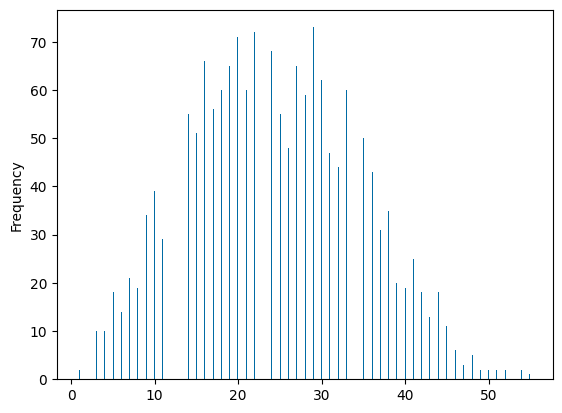

In [11]:
df_siniestros['cantidad_eventos'].plot(kind='hist', bins=500);

Outliers based on IQR:


cantidad_eventos
fecha                       
2019-04-16                54
2019-08-21                54
2021-12-17                55

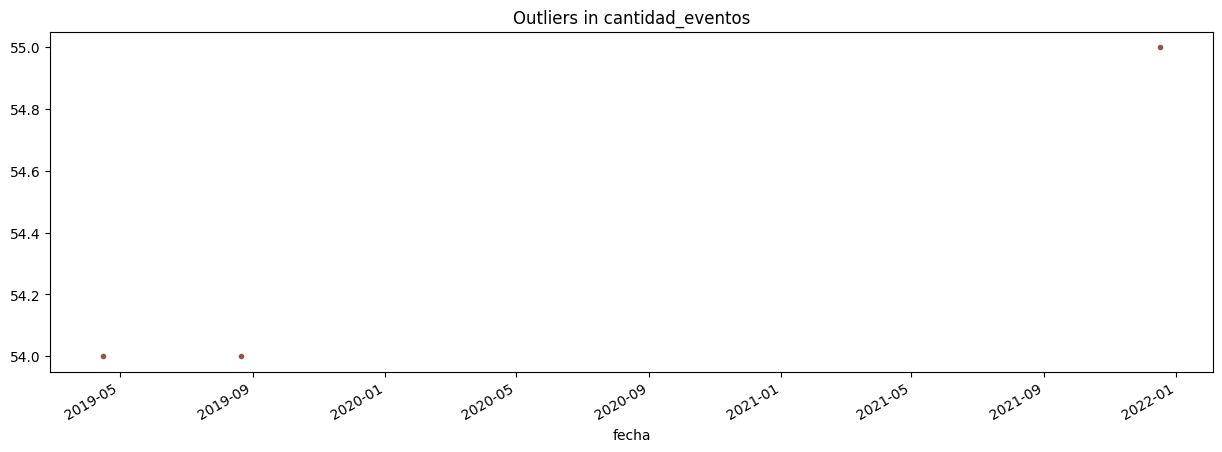

In [12]:
Q1 = df_siniestros['cantidad_eventos'].quantile(0.25)
Q3 = df_siniestros['cantidad_eventos'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_siniestros[(df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)]

print("Outliers based on IQR:")
display(outliers)

outliers['cantidad_eventos'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Outliers in cantidad_eventos')
plt.show()

In [13]:
#Lo que hago es modificar los outliers por el valor 53, que es el valor menor a que se considere outlier
condicion = (df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)
df_siniestros.loc[condicion, 'cantidad_eventos'] = 53

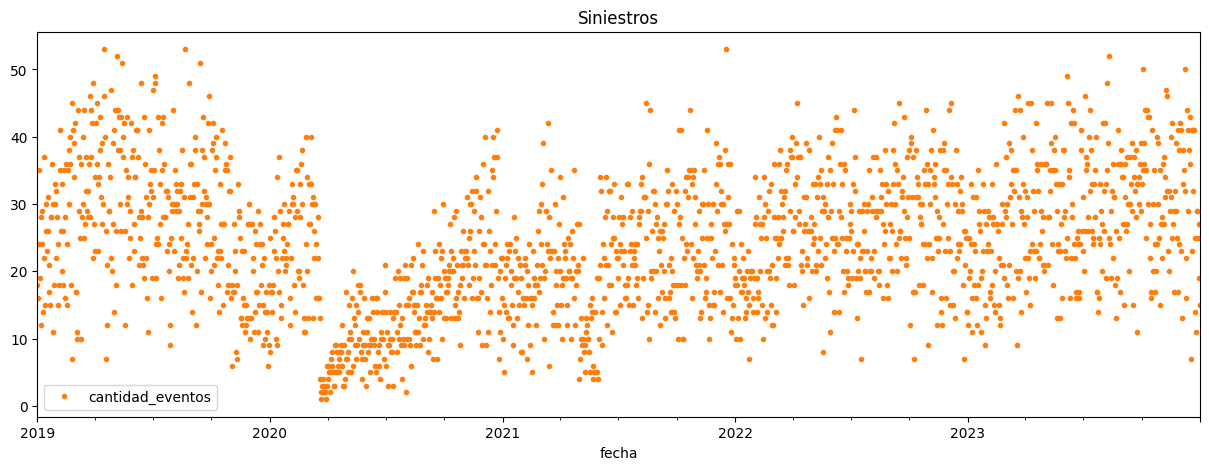

In [14]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

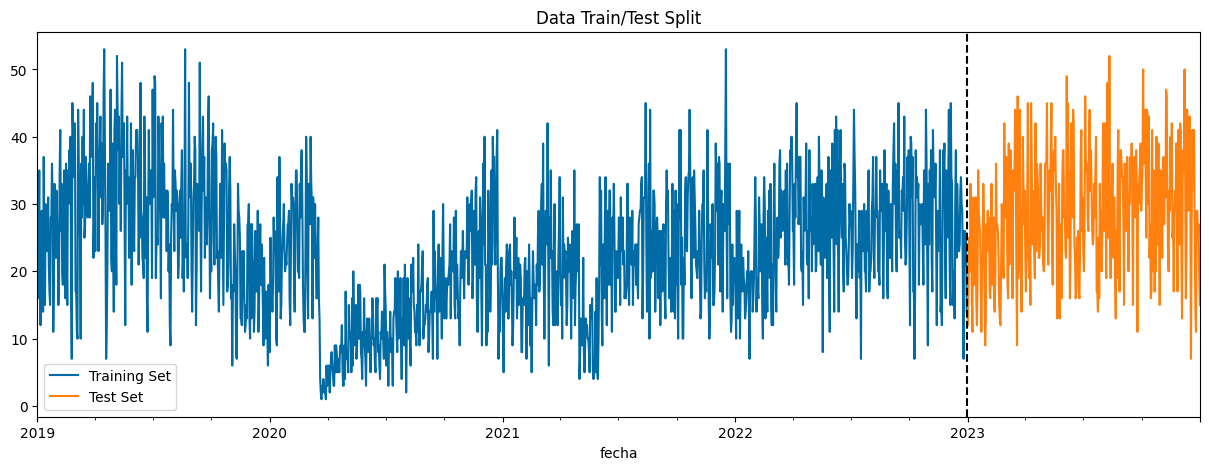

In [15]:
split_index = int(len(df_siniestros) * 0.8)
train_siniestros = df_siniestros.iloc[:split_index]
test_siniestros = df_siniestros.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train_siniestros.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_siniestros.plot(ax=ax, label='Test Set')
ax.axvline(test_siniestros.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.
n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [16]:
tss_siniestros = TimeSeriesSplit(n_splits=5, test_size=1*200*1, gap=1) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df_siniestros_cv = df_siniestros.sort_index()

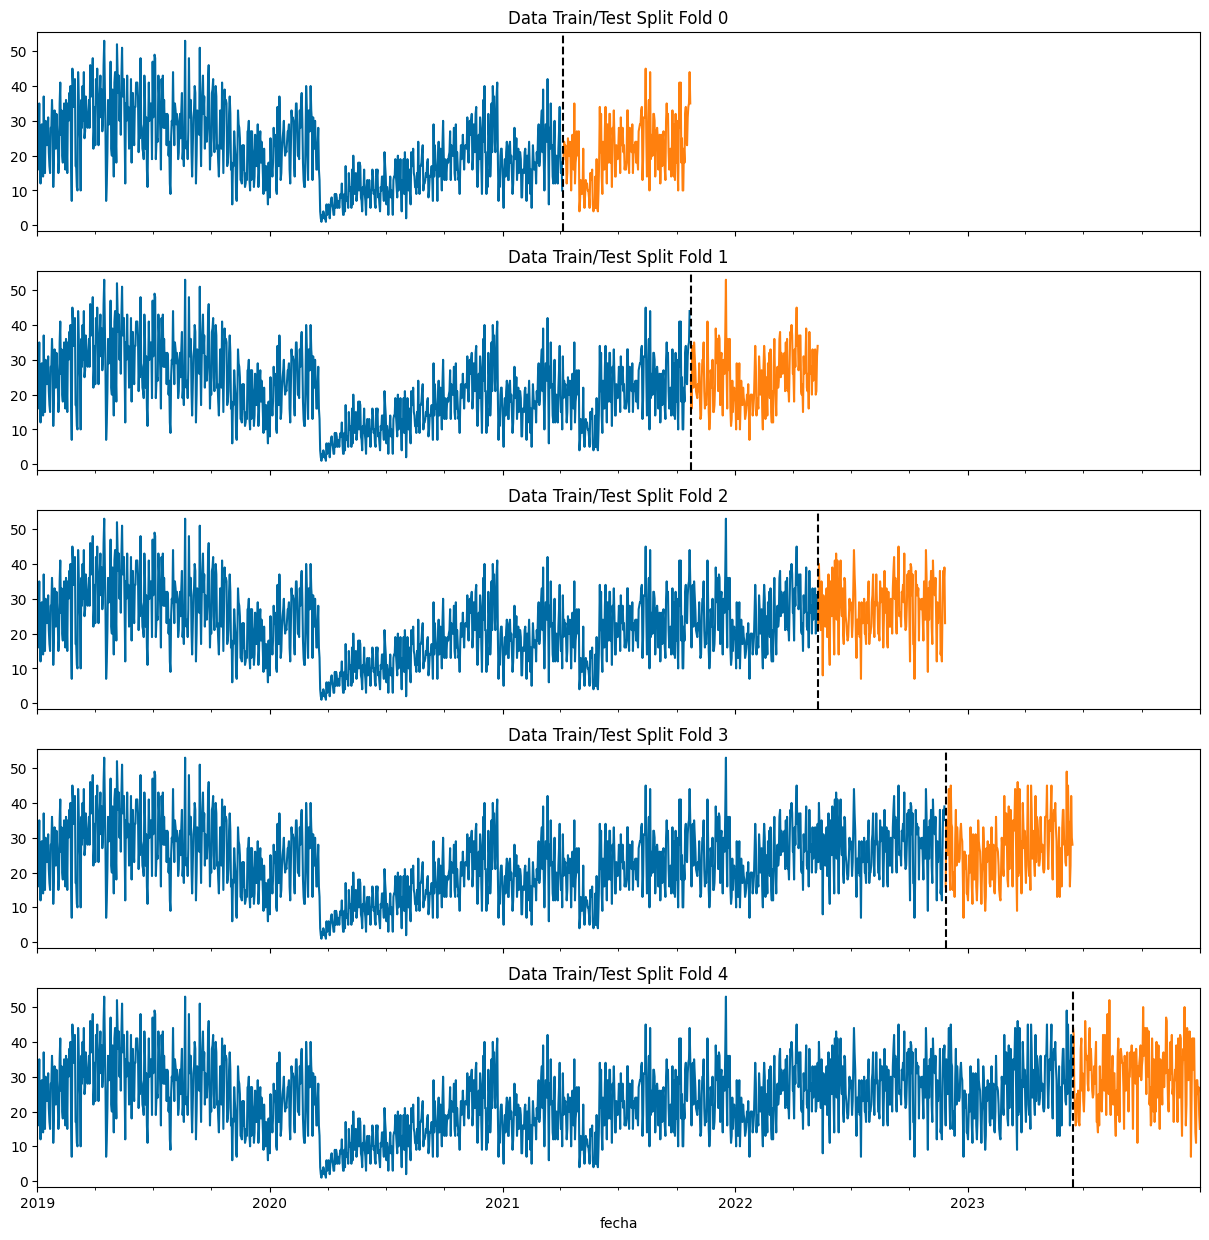

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss_siniestros.split(df_siniestros_cv):
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]
    train['cantidad_eventos'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['cantidad_eventos'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [18]:
tss_siniestros

TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=200)

In [19]:
for i, (train_index, test_index) in enumerate(tss_siniestros.split(df_siniestros_cv)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [20]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [21]:
df_siniestros_cv = create_features(df_siniestros_cv)

In [22]:
def add_lags(df):
    target_map = df['cantidad_eventos'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [23]:
df_siniestros_cv = add_lags(df_siniestros_cv)

In [24]:
df_siniestros_cv.head(3)

cantidad_eventos  hour  dayofweek  quarter  month  year  \
fecha                                                                 
2019-01-01                18     0          1        1      1  2019   
2019-01-02                16     0          2        1      1  2019   
2019-01-03                24     0          3        1      1  2019   

            dayofyear  dayofmonth  weekofyear  lag1  lag2  lag3  
fecha                                                            
2019-01-01          1           1           1   NaN   NaN   NaN  
2019-01-02          2           2           1   NaN   NaN   NaN  
2019-01-03          3           3           1   NaN   NaN   NaN

In [25]:
tss_siniestros_2 = TimeSeriesSplit(n_splits=5, test_size=200, gap=1)
df_siniestros_cv = df_siniestros_cv.sort_index()

In [26]:
fold = 0
preds = [] #Almacena las predicciones de cada partición
scores = [] #Guarda el RMSE de cada partición
for train_idx, val_idx in tss_siniestros_2.split(df_siniestros_cv): #Iterar sobre las particiones
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] #Extraer características y target
    TARGET = 'cantidad_eventos'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01,
                           eval_metric=['rmse', 'mae'] )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:10.72343	validation_0-mae:8.78479	validation_1-rmse:8.66924	validation_1-mae:7.04428
[100]	validation_0-rmse:7.57678	validation_0-mae:5.99368	validation_1-rmse:9.14662	validation_1-mae:7.39160
[200]	validation_0-rmse:6.72825	validation_0-mae:5.19142	validation_1-rmse:9.05097	validation_1-mae:7.31285


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:34:46] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:6.41834	validation_0-mae:4.90523	validation_1-rmse:9.00338	validation_1-mae:7.30798
[400]	validation_0-rmse:6.24619	validation_0-mae:4.75674	validation_1-rmse:8.97475	validation_1-mae:7.29652
[500]	validation_0-rmse:6.10861	validation_0-mae:4.63473	validation_1-rmse:8.74947	validation_1-mae:7.10669
[600]	validation_0-rmse:6.02094	validation_0-mae:4.55279	validation_1-rmse:8.83730	validation_1-mae:7.16783
[700]	validation_0-rmse:5.91563	validation_0-mae:4.45985	validation_1-rmse:8.87836	validation_1-mae:7.19299
[800]	validation_0-rmse:5.80611	validation_0-mae:4.36608	validation_1-rmse:8.91354	validation_1-mae:7.22781
[900]	validation_0-rmse:5.68267	validation_0-mae:4.27318	validation_1-rmse:8.97586	validation_1-mae:7.28724
[999]	validation_0-rmse:5.59016	validation_0-mae:4.20248	validation_1-rmse:9.00549	validation_1-mae:7.30354
[0]	validation_0-rmse:10.35255	validation_0-mae:8.43834	validation_1-rmse:8.59172	validation_1-mae:6.91659
[100]	validation_0-rmse:7.951

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:34:47] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.52105	validation_0-mae:5.07266	validation_1-rmse:9.39088	validation_1-mae:7.29461
[500]	validation_0-rmse:6.32318	validation_0-mae:4.89201	validation_1-rmse:9.48240	validation_1-mae:7.39223
[600]	validation_0-rmse:6.14601	validation_0-mae:4.72694	validation_1-rmse:9.66918	validation_1-mae:7.51475
[700]	validation_0-rmse:6.02110	validation_0-mae:4.61008	validation_1-rmse:9.78675	validation_1-mae:7.59725
[800]	validation_0-rmse:5.94560	validation_0-mae:4.53288	validation_1-rmse:9.80923	validation_1-mae:7.62253
[900]	validation_0-rmse:5.85959	validation_0-mae:4.45284	validation_1-rmse:9.86440	validation_1-mae:7.66929
[999]	validation_0-rmse:5.71632	validation_0-mae:4.34000	validation_1-rmse:9.97722	validation_1-mae:7.74403
[0]	validation_0-rmse:10.07582	validation_0-mae:8.21304	validation_1-rmse:9.47461	validation_1-mae:7.70149
[100]	validation_0-rmse:8.05099	validation_0-mae:6.45217	validation_1-rmse:8.89904	validation_1-mae:7.17076
[200]	validation_0-rmse:7.383

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:34:48] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.87144	validation_0-mae:5.39588	validation_1-rmse:7.91861	validation_1-mae:6.34754
[500]	validation_0-rmse:6.68182	validation_0-mae:5.22444	validation_1-rmse:7.82485	validation_1-mae:6.26247
[600]	validation_0-rmse:6.48183	validation_0-mae:5.04171	validation_1-rmse:7.59869	validation_1-mae:6.05357
[700]	validation_0-rmse:6.35306	validation_0-mae:4.92639	validation_1-rmse:7.48410	validation_1-mae:5.97321
[800]	validation_0-rmse:6.27140	validation_0-mae:4.85454	validation_1-rmse:7.44397	validation_1-mae:5.94250
[900]	validation_0-rmse:6.16786	validation_0-mae:4.76341	validation_1-rmse:7.28814	validation_1-mae:5.81645
[999]	validation_0-rmse:6.09868	validation_0-mae:4.70181	validation_1-rmse:7.24666	validation_1-mae:5.78655
[0]	validation_0-rmse:9.97200	validation_0-mae:8.16220	validation_1-rmse:9.58734	validation_1-mae:7.67605
[100]	validation_0-rmse:8.07490	validation_0-mae:6.47910	validation_1-rmse:8.58731	validation_1-mae:6.71044
[200]	validation_0-rmse:7.3780

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:34:48] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.75974	validation_0-mae:5.30415	validation_1-rmse:9.11147	validation_1-mae:6.87551
[500]	validation_0-rmse:6.56341	validation_0-mae:5.13271	validation_1-rmse:9.14884	validation_1-mae:6.81789
[600]	validation_0-rmse:6.38814	validation_0-mae:4.97675	validation_1-rmse:9.25728	validation_1-mae:6.85662
[700]	validation_0-rmse:6.25628	validation_0-mae:4.85784	validation_1-rmse:9.32409	validation_1-mae:6.87541
[800]	validation_0-rmse:6.15370	validation_0-mae:4.76473	validation_1-rmse:9.38678	validation_1-mae:6.90074
[900]	validation_0-rmse:6.05404	validation_0-mae:4.67988	validation_1-rmse:9.68918	validation_1-mae:7.11696
[999]	validation_0-rmse:5.95695	validation_0-mae:4.60048	validation_1-rmse:9.96825	validation_1-mae:7.32604
[0]	validation_0-rmse:9.91304	validation_0-mae:8.11711	validation_1-rmse:11.21255	validation_1-mae:9.25115
[100]	validation_0-rmse:8.02248	validation_0-mae:6.42303	validation_1-rmse:9.40692	validation_1-mae:7.67271
[200]	validation_0-rmse:7.459

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:34:49] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:6.87698	validation_0-mae:5.38974	validation_1-rmse:7.88500	validation_1-mae:6.32446
[500]	validation_0-rmse:6.68704	validation_0-mae:5.22861	validation_1-rmse:7.70953	validation_1-mae:6.15111
[600]	validation_0-rmse:6.53630	validation_0-mae:5.09858	validation_1-rmse:7.64810	validation_1-mae:6.08099
[700]	validation_0-rmse:6.42649	validation_0-mae:5.00276	validation_1-rmse:7.60649	validation_1-mae:6.03948
[800]	validation_0-rmse:6.34241	validation_0-mae:4.92968	validation_1-rmse:7.57120	validation_1-mae:5.99795
[900]	validation_0-rmse:6.24302	validation_0-mae:4.84435	validation_1-rmse:7.58361	validation_1-mae:6.00634
[999]	validation_0-rmse:6.17176	validation_0-mae:4.78168	validation_1-rmse:7.56990	validation_1-mae:5.98840


In [27]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.7535
Fold scores:[np.float64(9.005486829138398), np.float64(9.977221677029037), np.float64(7.2466646612188566), np.float64(9.968252522363656), np.float64(7.569902060516407)]


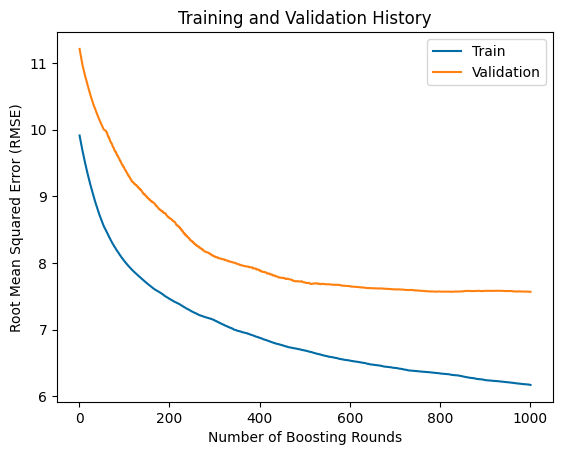

In [28]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

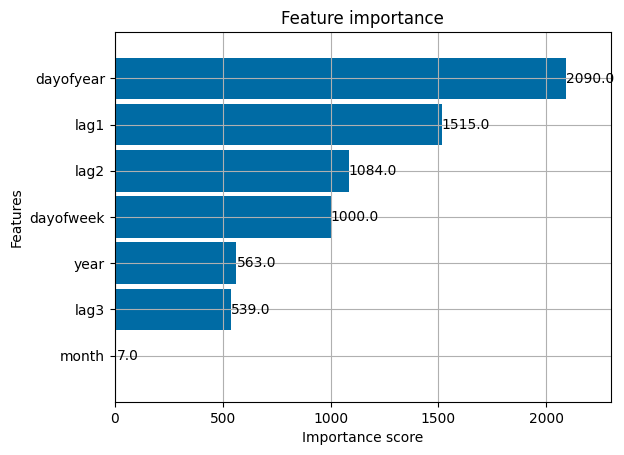

In [29]:
_ = plot_importance(reg, height=0.9)

In [30]:
y_pred = reg.predict(X_val)

In [31]:
y_pred

array([31.672134 , 31.92372  , 24.661922 , 14.929623 , 31.911171 ,
       32.312225 , 34.75364  , 31.895859 , 32.438076 , 24.388754 ,
       17.974316 , 31.25668  , 31.116299 , 31.719484 , 31.659716 ,
       31.772085 , 20.553198 , 19.332201 , 31.071383 , 32.292984 ,
       30.523264 , 33.00002  , 32.239655 , 19.90751  , 19.305956 ,
       29.823807 , 30.890888 , 31.57996  , 31.633322 , 31.894701 ,
       24.095047 , 18.24592  , 31.161789 , 31.121794 , 32.39227  ,
       31.746933 , 31.767645 , 24.23251  , 15.469797 , 31.051857 ,
       30.87434  , 32.397186 , 31.49189  , 34.87072  , 24.108192 ,
       17.069826 , 31.37758  , 31.059227 , 31.902851 , 31.55214  ,
       33.84128  , 20.555191 , 17.996067 , 30.411999 , 32.005554 ,
       33.72912  , 32.694405 , 29.418163 , 20.595436 , 17.996067 ,
       29.55678  , 32.209858 , 30.01621  , 32.003067 , 29.088133 ,
       24.638527 , 17.410774 , 31.497196 , 31.99478  , 32.81379  ,
       32.694405 , 31.869461 , 24.1896   , 17.410774 , 31.1438

In [32]:
val['prediction'] = reg.predict(X_val)

/tmp/ipython-input-1799221841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [33]:
val['prediction']

fecha
2023-06-15    31.672134
2023-06-16    31.923719
2023-06-17    24.661922
2023-06-18    14.929623
2023-06-19    31.911171
                ...    
2023-12-27    26.831644
2023-12-28    26.872234
2023-12-29    25.024164
2023-12-30    20.233740
2023-12-31    10.868751
Name: prediction, Length: 200, dtype: float32

In [34]:
val

cantidad_eventos  hour  dayofweek  quarter  month  year  \
fecha                                                                 
2023-06-15                44     0          3        2      6  2023   
2023-06-16                42     0          4        2      6  2023   
2023-06-17                24     0          5        2      6  2023   
2023-06-18                22     0          6        2      6  2023   
2023-06-19                16     0          0        2      6  2023   
...                      ...   ...        ...      ...    ...   ...   
2023-12-27                29     0          2        4     12  2023   
2023-12-28                25     0          3        4     12  2023   
2023-12-29                27     0          4        4     12  2023   
2023-12-30                19     0          5        4     12  2023   
2023-12-31                15     0          6        4     12  2023   

            dayofyear  dayofmonth  weekofyear  lag1  lag2  lag3  prediction  
fecha                                                                        
2023-06-15        166          15          24  28.0  32.0  16.0   31.672134  
2023-06-16        167          16          24  25.0  32.0   8.0   31.923719  
2023-06-17        168          17          24  33.0  18.0   9.0   24.661922  
2023-06-18        169          18          24  20.0  24.0   6.0   14.929623  
2023-06-19        170          19          25  17.0  11.0   4.0   31.911171  
...               ...         ...         ...   ...   ...   ...         ...  
2023-12-27        361          27          52  21.0  21.0  22.0   26.831644  
2023-12-28        362          28          52  25.0  22.0  16.0   26.872234  
2023-12-29        363          29          52  14.0  19.0  10.0   25.024164  
2023-12-30        364          30          52  14.0  18.0   5.0   20.233740  
2023-12-31        365          31          52  12.0  10.0  15.0   10.868751  

[200 rows x 13 columns]

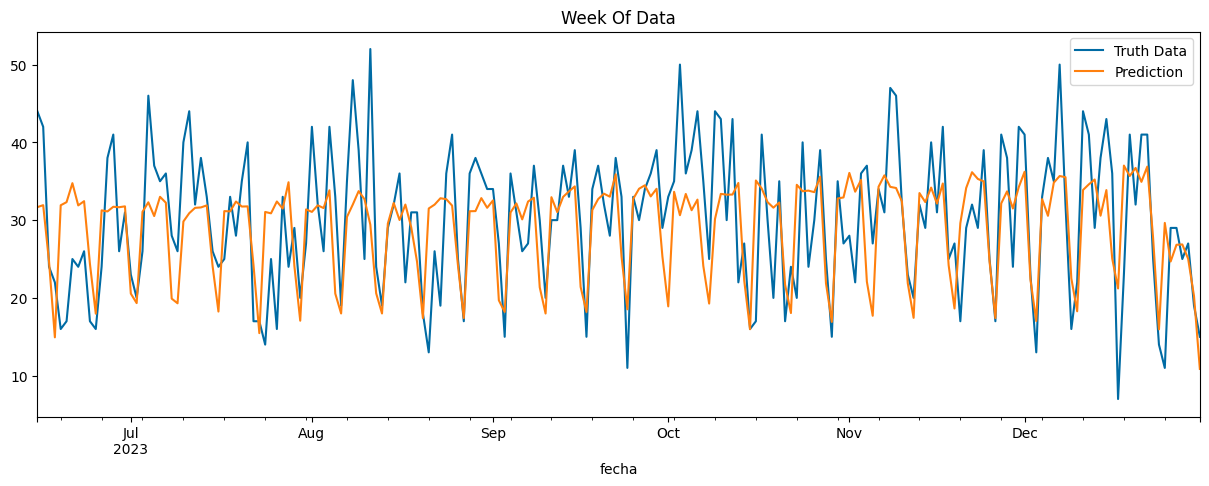

In [35]:
ax = val.loc[(val.index >= '2017-08-03')]['cantidad_eventos'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [36]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [37]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 57.30341720581055
Mean Absolute Error (MAE): 5.988396644592285
RMSE Score on Test set: 7.57


[I 2025-10-08 15:35:15,302] A new study created in memory with name: no-name-e4c18439-97d9-4a6d-9a4f-0257d05d42dd
[I 2025-10-08 15:35:22,283] Trial 0 finished with value: 7.529316997440203 and parameters: {'n_estimators': 106, 'max_depth': 7, 'learning_rate': 0.015783817301800937, 'subsample': 0.8202241992080411, 'colsample_bytree': 0.7790129446889581, 'reg_alpha': 2.1668814603081485e-05, 'reg_lambda': 0.36745346908875065}. Best is trial 0 with value: 7.529316997440203.
[I 2025-10-08 15:35:36,069] Trial 1 finished with value: 7.727202227472901 and parameters: {'n_estimators': 437, 'max_depth': 6, 'learning_rate': 0.09819701826847128, 'subsample': 0.701032402988557, 'colsample_bytree': 0.8781343395319574, 'reg_alpha': 5.361697107357419e-05, 'reg_lambda': 3.0811566502631358e-06}. Best is trial 0 with value: 7.529316997440203.
[I 2025-10-08 15:35:56,651] Trial 2 finished with value: 7.823989402067399 and parameters: {'n_estimators': 724, 'max_depth': 8, 'learning_rate': 0.0969168192623759

Best hyperparameters:  {'n_estimators': 734, 'max_depth': 9, 'learning_rate': 0.013435164780181832, 'subsample': 0.6018308627996675, 'colsample_bytree': 0.8466574330551211, 'reg_alpha': 0.022979018410615844, 'reg_lambda': 1.3184656341485535e-06}
Best RMSE:  7.392708563441433


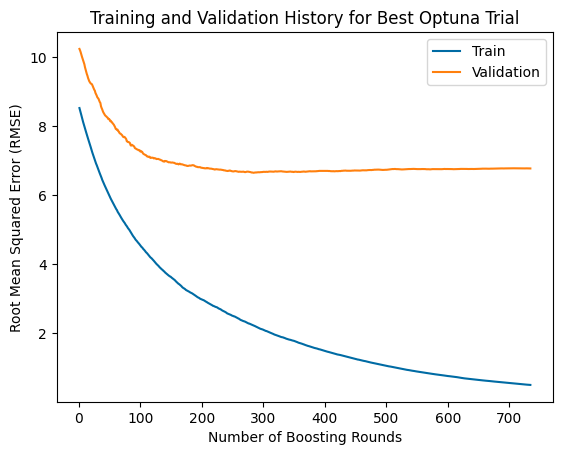

In [40]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
    rmse_scores = []

    df_processed = create_features(df_siniestros_cv.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] # Update feature names
    TARGET = 'cantidad_eventos'

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

## Entrenamiento del modelo final

Entrenar el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna en el conjunto de datos completo de entrenamiento.

In [41]:
# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'cantidad_eventos'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_siniestros_cv.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-07-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8466574330551211, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.013435164780181832,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=734, n_jobs=-1,
             num_parallel_tree=None, ...)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 8.16
Final Model MAE on Test Set: 6.47


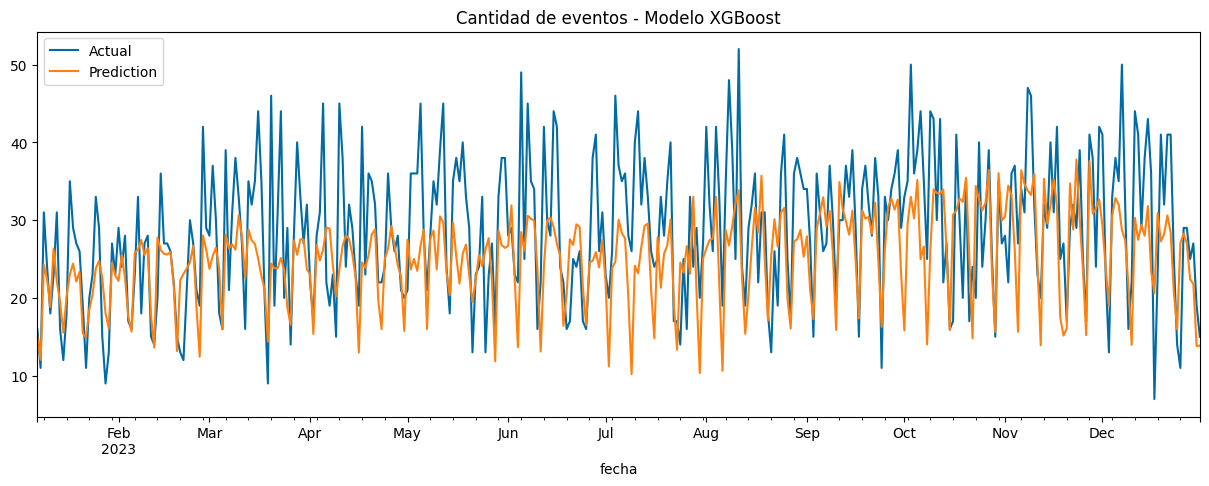

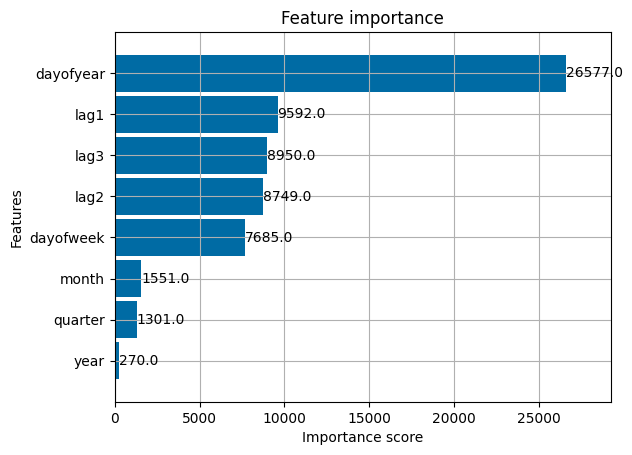

In [43]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Cantidad de eventos - Modelo XGBoost')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

IMPORTANTE: En este punto reiniciar session de colab antes de descargar los pesos del modelo

In [ ]:
# 2. Importaciones y carga del modelo
import timesfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True, # Importante para siniestros, que no pueden ser negativos
        fix_quantile_crossing=True,
    )
)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [46]:
# 3. Preparación de tus datos
HORIZON = 30 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_siniestros_TFM = df_siniestros.copy()
split_index = int(len(data_siniestros_TFM) * 0.8)
train_siniestros_TFM = data_siniestros_TFM[:split_index]
test_siniestros_TFM = data_siniestros_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_siniestros_TFM['cantidad_eventos'][-1024:].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1024)


In [47]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_siniestros = point_forecast[0]

print(f"Se generaron {len(prediccion_siniestros)} predicciones para los próximos {HORIZON} días.")

Se generaron 30 predicciones para los próximos 30 días.


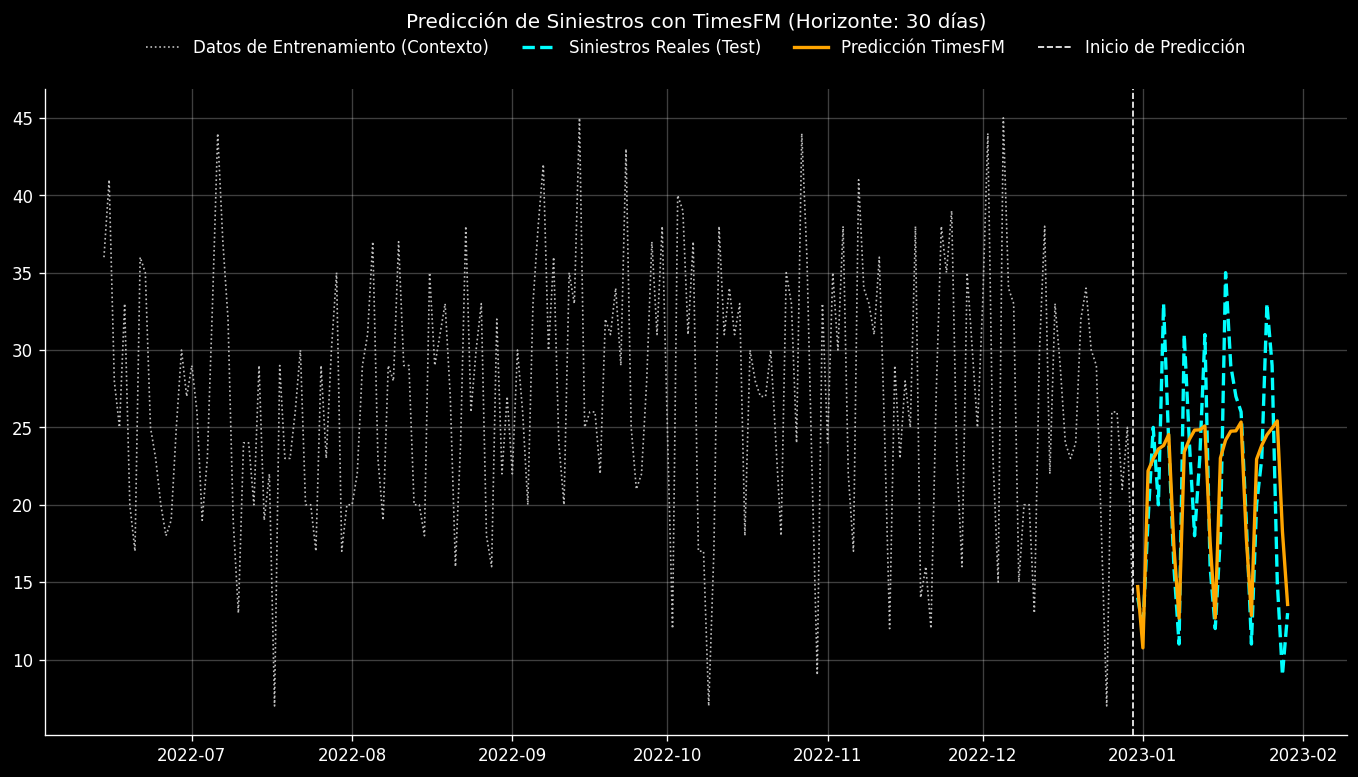

In [48]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_siniestros_TFM['cantidad_eventos'].iloc[:HORIZON].values,
    'Predichos': prediccion_siniestros
}, index=test_siniestros_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_siniestros_TFM.index[-200:], train_siniestros_TFM['cantidad_eventos'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Siniestros Reales (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_siniestros_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Siniestros con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_resultados['Reales'], df_resultados['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

Resultados de las métricas de error:
Error Absoluto Medio (MAE): 3.69
Raíz del Error Cuadrático Medio (RMSE): 4.92


## TimesFM_2

Forma de los datos de entrada para el modelo: (4, 365)
Se generaron 30 predicciones para los próximos 30 días.


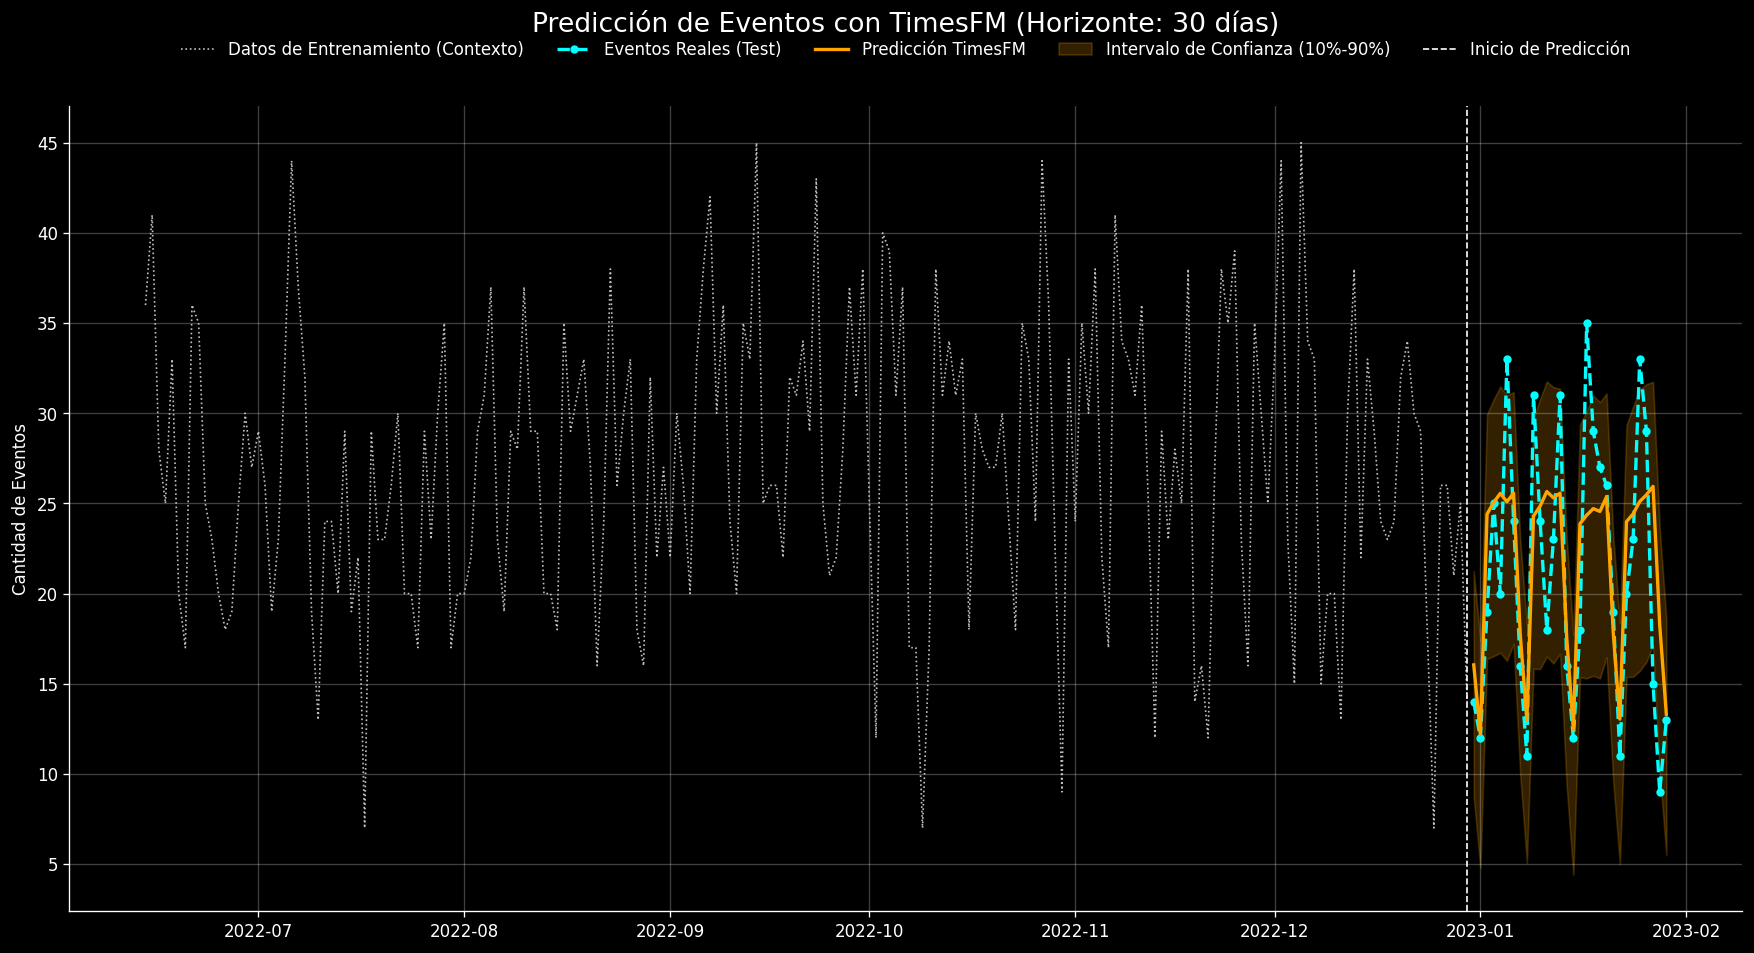

In [50]:
from sklearn.preprocessing import StandardScaler
# Configurar el modelo para la inferencia
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)

# ==============================================================================
# PASO 2: PREPARACIÓN DE DATOS Y FEATURE ENGINEERING
# ==============================================================================
# --- Asegúrate de que tu DataFrame 'df_siniestros' esté cargado aquí ---
# Por ejemplo:
# df_siniestros = pd.read_csv('tus_datos.csv', parse_dates=['fecha'], index_col='fecha')


# Definir la columna objetivo y el horizonte
TARGET_COLUMN = 'cantidad_eventos'
HORIZON = 30
CONTEXT_WINDOW = 365 # Puedes experimentar cambiando este valor (ej. 365)

# Crear características basadas en la fecha
# Es crucial que el índice de tu DataFrame sea de tipo DatetimeIndex
df_siniestros_featured = df_siniestros.copy()
df_siniestros_featured['dia_de_semana'] = df_siniestros_featured.index.dayofweek
df_siniestros_featured['dia_del_mes'] = df_siniestros_featured.index.day
df_siniestros_featured['mes'] = df_siniestros_featured.index.month

# Normalizar las nuevas características
scaler = StandardScaler()
features_to_scale = ['dia_de_semana', 'dia_del_mes', 'mes']
df_siniestros_featured[features_to_scale] = scaler.fit_transform(
    df_siniestros_featured[features_to_scale]
)

# Dividir en datos de entrenamiento y prueba
split_index = int(len(df_siniestros_featured) * 0.8)
train_data = df_siniestros_featured[:split_index]
test_data = df_siniestros_featured[split_index:]

# ==============================================================================
# PASO 3: PREPARAR INPUTS PARA EL MODELO
# ==============================================================================
# Definir las columnas que usaremos, con la objetivo SIEMPRE PRIMERO
feature_columns = [TARGET_COLUMN] + features_to_scale

# Extraer el contexto del final del set de entrenamiento
context_data = train_data[feature_columns][-CONTEXT_WINDOW:].to_numpy()

# Transponer para obtener la forma correcta: (num_features, context_length)
model_inputs = context_data.T

print(f"Forma de los datos de entrada para el modelo: {model_inputs.shape}")

# ==============================================================================
# PASO 4: REALIZAR LA PREDICCIÓN
# ==============================================================================
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=model_inputs
)

# Extraer la predicción principal y los cuantiles para el intervalo de confianza
predicted_values = point_forecast[0]
q10 = quantile_forecast[0, :, 1] # Cuantil 10
q90 = quantile_forecast[0, :, 8] # Cuantil 90

print(f"Se generaron {len(predicted_values)} predicciones para los próximos {HORIZON} días.")

# ==============================================================================
# PASO 5: VISUALIZACIÓN DE RESULTADOS
# ==============================================================================
# Crear un DataFrame para facilitar la comparación
df_results = pd.DataFrame({
    'Reales': test_data[TARGET_COLUMN].iloc[:HORIZON].values,
    'Predichos': predicted_values,
    'Cuantil_10': q10,
    'Cuantil_90': q90
}, index=test_data.index[:HORIZON])

# Graficar los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8), dpi=120)

# 1. Datos de entrenamiento (últimos 200 puntos como contexto)
ax.plot(train_data.index[-200:], train_data[TARGET_COLUMN][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# 2. Datos reales del período de prueba
ax.plot(df_results.index, df_results['Reales'],
        ls='--', lw=2, marker='o', markersize=4, color='cyan', label='Eventos Reales (Test)')

# 3. Predicción puntual del modelo
ax.plot(df_results.index, df_results['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# 4. Intervalo de confianza
ax.fill_between(df_results.index, df_results['Cuantil_10'], df_results['Cuantil_90'],
                color='orange', alpha=0.2, label='Intervalo de Confianza (10%-90%)')

# 5. Línea vertical para marcar el inicio de la predicción
ax.axvline(train_data.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.legend(frameon=False, ncols=5, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Eventos con TimesFM (Horizonte: {HORIZON} días)", y=1.08, fontsize=16)
ax.set_ylabel("Cantidad de Eventos")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

Resultados de las métricas de error:
Error Absoluto Medio (MAE): 3.86
Raíz del Error Cuadrático Medio (RMSE): 5.02


## Chronos

In [ ]:
## Parametros
pipeline = ChronosPipeline.from_pretrained(
    #"amazon/chronos-t5-small",
    "amazon/chronos-t5-large",
    device_map="auto",  # "cpu" o "mps" para Apple Silicon  cuda
    torch_dtype=torch.bfloat16,
)

In [53]:
## Parametros de prediccion
step_to_predict= 45  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider= 2 # Simula 5 futuros posibles para entender mejor lo que puede pasar

In [54]:
## Proyeccion
forecast = pipeline.predict(
    context=torch.tensor(df_siniestros["cantidad_eventos"]),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = range(len(df_siniestros), len(df_siniestros) + step_to_predict)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

/tmp/ipython-input-1307425459.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df_siniestros["cantidad_eventos"]),


In [55]:
predicted_mean = forecast.mean(axis=0)
print(predicted_mean)

tensor([[23.0196, 27.9968, 30.0706, 26.9599, 30.9001, 23.0196, 10.9913, 20.9457,
         29.0337, 25.0934, 35.0478, 25.0934, 24.0565,  8.9175, 26.9599, 18.0424,
         40.0250, 38.9881, 31.9371, 15.9685, 13.0652, 19.9088, 31.9371, 25.9229,
         42.0989, 26.9599, 24.0565, 23.0196, 21.9827, 18.0424, 10.9913, 26.9599,
         20.9457, 23.0196, 25.0934, 23.0196, 23.0196, 29.0337, 32.9740, 17.0054,
         21.9827, 13.0652, 36.9143, 36.0847, 30.9001],
        [30.9001, 19.9088, 26.9599, 27.9968, 24.0565, 21.9827, 23.0196, 20.1162,
         30.9001, 29.0337, 15.9685, 25.9229, 24.0565, 18.0424, 34.0109, 37.9512,
         35.0478, 27.9968, 27.9968, 24.0565,  9.9544, 32.9740, 35.0478, 29.0337,
         45.0022, 30.0706, 36.0847, 31.9371, 30.0706, 47.9056, 42.0989, 32.9740,
         29.0337, 24.0565, 17.0054, 25.9229, 25.9229, 35.0478, 37.9512, 42.0989,
         14.1021, 15.9685, 24.0565, 35.0478, 24.0565]])


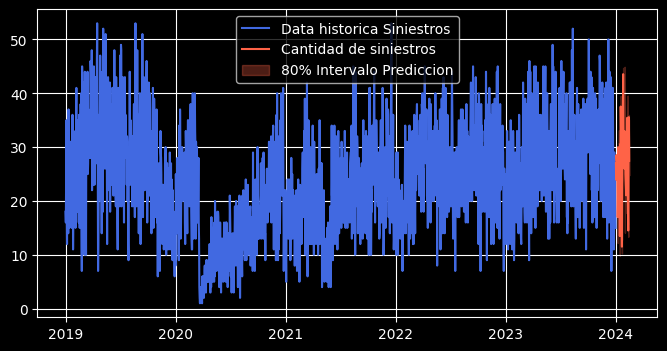

In [56]:
# Grafico
plt.figure(figsize=(8, 4))
plt.plot(df_siniestros["cantidad_eventos"], color="royalblue", label="Data historica Siniestros")
# Modified: Plot the median prediction starting from the end of the historical data index
plt.plot(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), median, color="tomato", label="Cantidad de siniestros")
plt.fill_between(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), low, high, color="tomato", alpha=0.3, label="80% Intervalo Prediccion")
plt.legend()
plt.grid()
plt.show()

## Chronos_2

In [57]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline

In [58]:
n_test = 25
df_siniestros_chronos_train = df_siniestros[:-n_test]
df_siniestros_chronos_test = df_siniestros[-n_test:]

In [59]:
df_siniestros_chronos_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2023-12-07 to 2023-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   cantidad_eventos  25 non-null     int64
dtypes: int64(1)
memory usage: 400.0 bytes


In [60]:
fechas_train = df_siniestros_chronos_train.index
fechas_test = df_siniestros_chronos_test.index

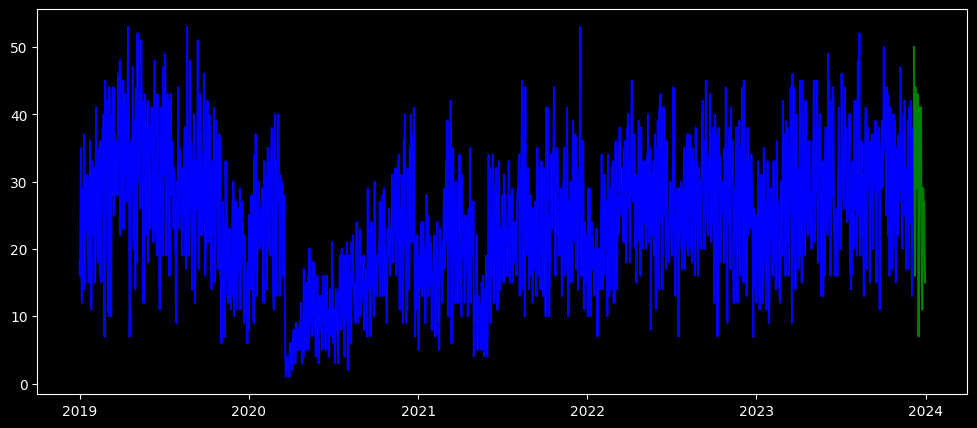

In [61]:
plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_siniestros_chronos_train["cantidad_eventos"], label="Entrenamiento", color="blue")
plt.plot(fechas_test, df_siniestros_chronos_test ["cantidad_eventos"], label="Test real", color="green")

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [63]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_siniestros_chronos_train["cantidad_eventos"]),
    prediction_length=n_test,
    quantile_levels=[0.1, 0.5, 0.9],
)

'''
El codigo nos da =
quantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.
quantiles[0.5] = idem pero para la mediana.
quantiles[0.9]= para el cuantil 90%.
mean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.
'''

/tmp/ipython-input-3408669728.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df_siniestros_chronos_train["cantidad_eventos"]),


'\nEl codigo nos da =\nquantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.\nquantiles[0.5] = idem pero para la mediana.\nquantiles[0.9]= para el cuantil 90%.\nmean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.\n'

In [64]:
# Aca imprime la ayuda del metodo
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

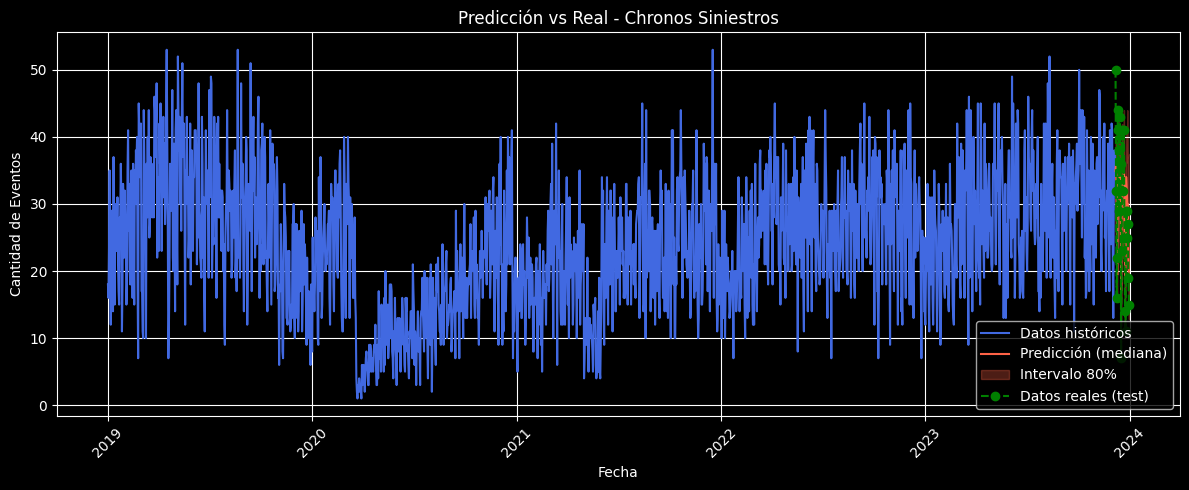

In [65]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np # Import numpy

# Extract quantiles and median from the prediction results
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Get the actual values from the test set
actual = df_siniestros_chronos_test["cantidad_eventos"].values

# Get the last date from the training set index
last_train_date = fechas_train[-1]

# Create a date range for the forecast starting from the day after the last training date
# The length of the forecast dates should match the length of the median prediction
forecast_dates = [last_train_date + timedelta(days=i) for i in range(1, len(median) + 1)]


plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_siniestros_chronos_train["cantidad_eventos"], color="royalblue", label="Datos históricos")
plt.plot(forecast_dates, median, color="tomato", label="Predicción (mediana)")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="Intervalo 80%")
plt.plot(fechas_test, actual, color="green", linestyle="--", marker="o", label="Datos reales (test)")

plt.legend()
plt.grid()
plt.title("Predicción vs Real - Chronos Siniestros")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE for Chronos
rmse_chronos = np.sqrt(mean_squared_error(actual, median))

# Calculate MAE for Chronos
mae_chronos = mean_absolute_error(actual, median)

print(f"Chronos Model RMSE on Test Set: {rmse_chronos:0.2f}")
print(f"Chronos Model MAE on Test Set: {mae_chronos:0.2f}")

Chronos Model RMSE on Test Set: 7.60
Chronos Model MAE on Test Set: 6.63


# Precipitaciones

In [67]:
df_precipitaciones.rename(columns={'Unnamed: 0': 'fecha'}, inplace=True)
df_precipitaciones.head()

fecha  (mm)
0 2019-01-01   2.0
1 2019-01-02   9.0
2 2019-01-03   0.0
3 2019-01-04   0.0
4 2019-01-05   1.0

In [68]:
df_precipitaciones.set_index('fecha', inplace=True)

## XGBoost

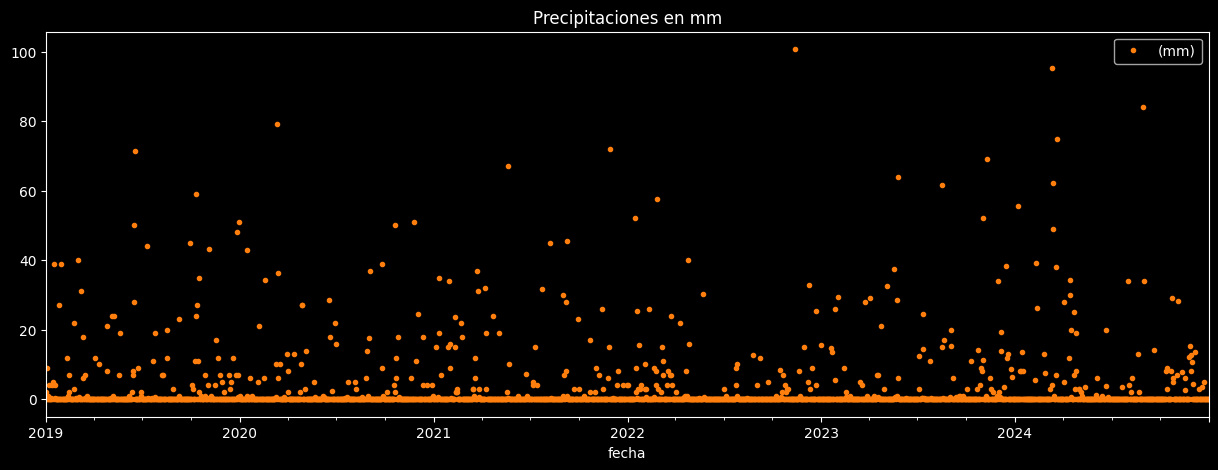

In [69]:
df_precipitaciones.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Precipitaciones en mm')
plt.show()

In [70]:
print('Cantidad de NaNs:')
for column in df_precipitaciones:
    nans = df_precipitaciones[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna (mm): 0


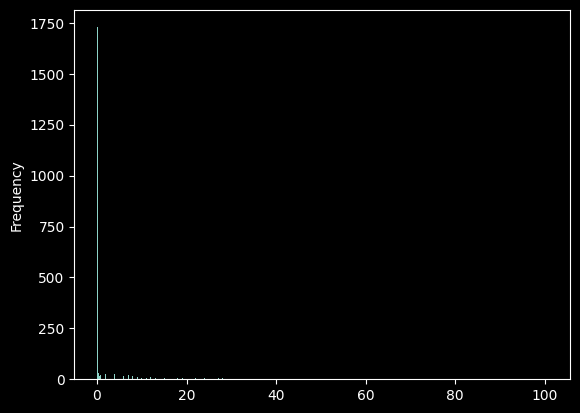

In [71]:
df_precipitaciones['(mm)'].plot(kind='hist', bins=500);

Outliers based on IQR:


(mm)
fecha           
2019-01-01   2.0
2019-01-02   9.0
2019-01-05   1.0
2019-01-06   4.0
2019-01-10   0.4
...          ...
2024-12-01   4.5
2024-12-05  13.7
2024-12-13   3.0
2024-12-18   3.5
2024-12-23   5.0

[504 rows x 1 columns]

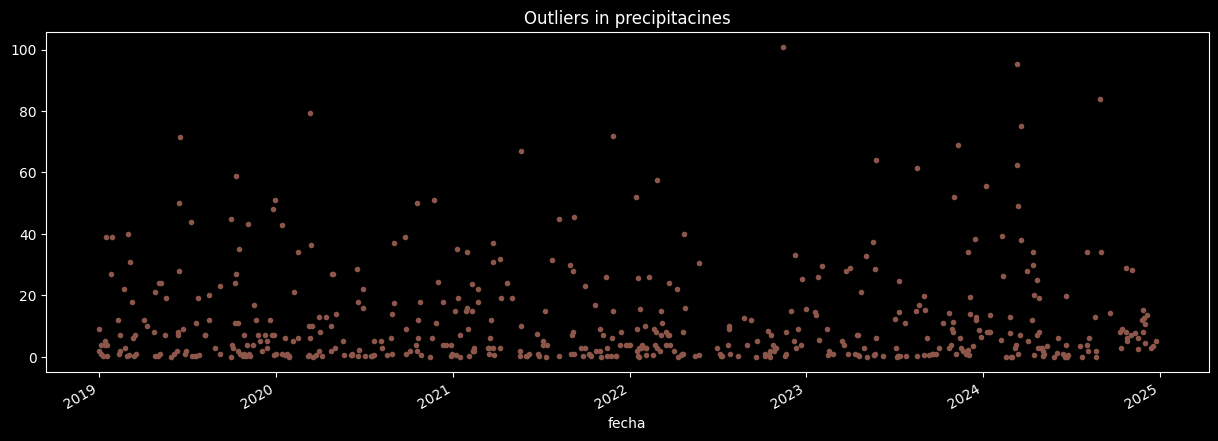

In [72]:
Q1 = df_precipitaciones['(mm)'].quantile(0.25)
Q3 = df_precipitaciones['(mm)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_precipitaciones[(df_precipitaciones['(mm)'] < lower_bound) | (df_precipitaciones['(mm)'] > upper_bound)]

print("Outliers based on IQR:")
display(outliers)

outliers['(mm)'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Outliers in precipitacines')
plt.show()

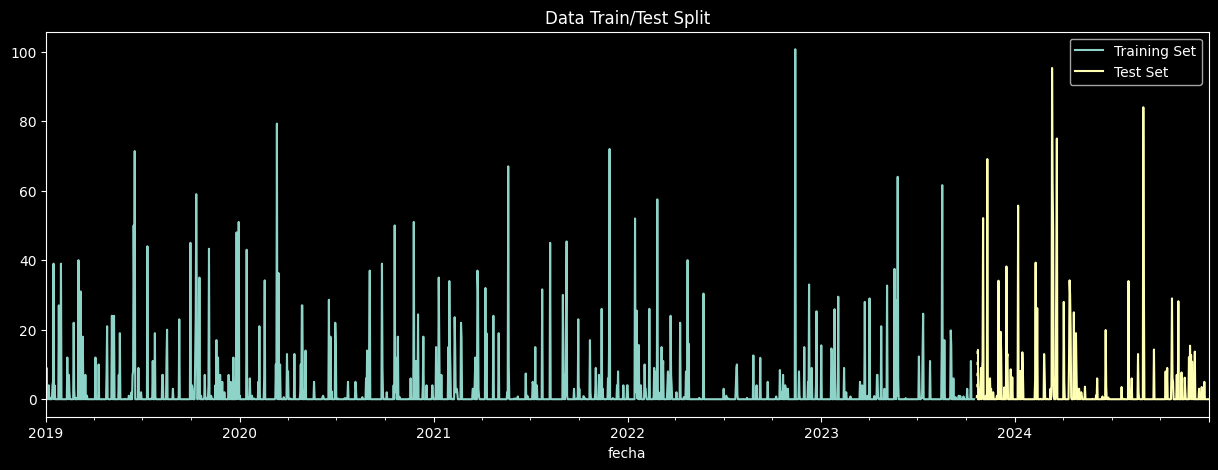

In [73]:
split_index = int(len(df_precipitaciones) * 0.8)
train_precipitaciones = df_precipitaciones.iloc[:split_index]
test_precipitaciones = df_precipitaciones.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train_precipitaciones.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_precipitaciones.plot(ax=ax, label='Test Set')
ax.axvline(test_precipitaciones.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [74]:
tss_precipitaciones = TimeSeriesSplit(n_splits=5, test_size=1*200*1, gap=1) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df_precipitaciones_cv = df_precipitaciones.sort_index()

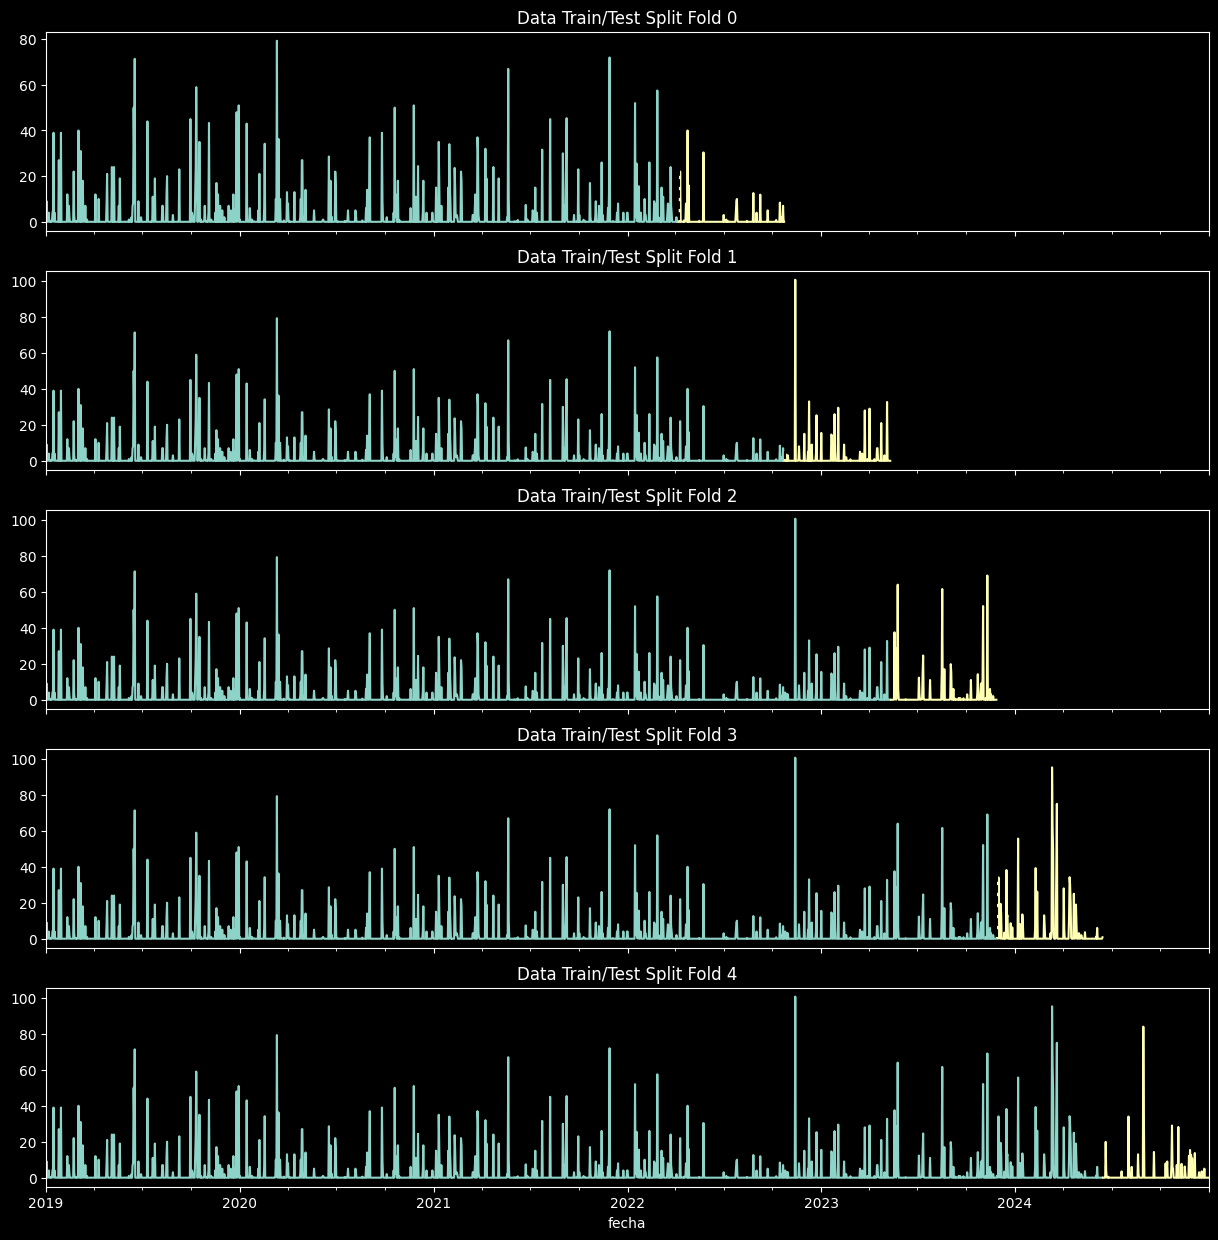

In [75]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss_precipitaciones.split(df_precipitaciones_cv):
    train = df_precipitaciones_cv.iloc[train_idx]
    val = df_precipitaciones_cv.iloc[val_idx]
    train['(mm)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['(mm)'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [76]:
for i, (train_index, test_index) in enumerate(tss_precipitaciones.split(df_precipitaciones_cv)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 1188 1189 1190]
  Test:  index=[1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205
 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219
 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233
 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247
 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261
 1262 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275
 1276 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289
 1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303
 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317
 1318 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331
 1332 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345
 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357 1358 1359
 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373
 13

In [77]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [78]:
df_precipitaciones_cv = create_features(df_precipitaciones_cv)

In [79]:
def add_lags(df):
    target_map = df['(mm)'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [80]:
df_precipitaciones_cv = add_lags(df_precipitaciones_cv)

In [81]:
tss_precipitaciones_2 = TimeSeriesSplit(n_splits=5, test_size=200, gap=1)
df_precipitaciones_cv = df_precipitaciones_cv.sort_index()

In [82]:
fold = 0
preds = [] #Almacena las predicciones de cada partición
scores = [] #Guarda el RMSE de cada partición
for train_idx, val_idx in tss_precipitaciones_2.split(df_precipitaciones_cv): #Iterar sobre las particiones
    train = df_precipitaciones_cv.iloc[train_idx]
    val = df_precipitaciones_cv.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] #Extraer características y target
    TARGET = '(mm)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01,
                           eval_metric=['rmse', 'mae'] )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:8.82647	validation_0-mae:4.55858	validation_1-rmse:4.71107	validation_1-mae:3.27813
[100]	validation_0-rmse:8.61192	validation_0-mae:4.41570	validation_1-rmse:4.62776	validation_1-mae:3.04066
[200]	validation_0-rmse:8.47915	validation_0-mae:4.32545	validation_1-rmse:4.59596	validation_1-mae:2.90265
[300]	validation_0-rmse:8.33504	validation_0-mae:4.25532	validation_1-rmse:4.56993	validation_1-mae:2.78418


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[400]	validation_0-rmse:8.21967	validation_0-mae:4.19619	validation_1-rmse:4.58276	validation_1-mae:2.75091
[500]	validation_0-rmse:8.11238	validation_0-mae:4.14327	validation_1-rmse:4.59951	validation_1-mae:2.71881
[600]	validation_0-rmse:8.00633	validation_0-mae:4.09057	validation_1-rmse:4.60590	validation_1-mae:2.66740
[700]	validation_0-rmse:7.91173	validation_0-mae:4.04146	validation_1-rmse:4.60022	validation_1-mae:2.64223
[800]	validation_0-rmse:7.83580	validation_0-mae:4.00000	validation_1-rmse:4.60740	validation_1-mae:2.63663
[900]	validation_0-rmse:7.75068	validation_0-mae:3.95818	validation_1-rmse:4.62225	validation_1-mae:2.61763
[999]	validation_0-rmse:7.68996	validation_0-mae:3.92692	validation_1-rmse:4.63796	validation_1-mae:2.61566
[0]	validation_0-rmse:8.35623	validation_0-mae:4.19397	validation_1-rmse:9.16508	validation_1-mae:4.09553
[100]	validation_0-rmse:8.17640	validation_0-mae:4.07264	validation_1-rmse:9.17802	validation_1-mae:3.98724
[200]	validation_0-rmse:8.0665

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:44:08] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:7.94647	validation_0-mae:3.93260	validation_1-rmse:9.22051	validation_1-mae:3.95048
[400]	validation_0-rmse:7.79969	validation_0-mae:3.86249	validation_1-rmse:9.28234	validation_1-mae:3.96554
[500]	validation_0-rmse:7.70229	validation_0-mae:3.81685	validation_1-rmse:9.33311	validation_1-mae:4.00028
[600]	validation_0-rmse:7.61836	validation_0-mae:3.77920	validation_1-rmse:9.37534	validation_1-mae:4.00924
[700]	validation_0-rmse:7.49905	validation_0-mae:3.72242	validation_1-rmse:9.40123	validation_1-mae:4.02970
[800]	validation_0-rmse:7.41613	validation_0-mae:3.68504	validation_1-rmse:9.42143	validation_1-mae:4.04441
[900]	validation_0-rmse:7.35378	validation_0-mae:3.65287	validation_1-rmse:9.44446	validation_1-mae:4.06532
[999]	validation_0-rmse:7.30057	validation_0-mae:3.62177	validation_1-rmse:9.45653	validation_1-mae:4.08226
[0]	validation_0-rmse:8.46379	validation_0-mae:4.16736	validation_1-rmse:9.78065	validation_1-mae:4.42732
[100]	validation_0-rmse:8.3300

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:44:09] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[200]	validation_0-rmse:8.23287	validation_0-mae:4.01264	validation_1-rmse:9.78536	validation_1-mae:3.96804
[300]	validation_0-rmse:8.16037	validation_0-mae:3.96188	validation_1-rmse:9.79999	validation_1-mae:3.88214
[400]	validation_0-rmse:8.07804	validation_0-mae:3.91549	validation_1-rmse:9.80508	validation_1-mae:3.79642
[500]	validation_0-rmse:7.99845	validation_0-mae:3.87421	validation_1-rmse:9.80450	validation_1-mae:3.75626
[600]	validation_0-rmse:7.90673	validation_0-mae:3.83000	validation_1-rmse:9.80840	validation_1-mae:3.70802
[700]	validation_0-rmse:7.82523	validation_0-mae:3.79120	validation_1-rmse:9.82164	validation_1-mae:3.67187
[800]	validation_0-rmse:7.72195	validation_0-mae:3.75265	validation_1-rmse:9.84623	validation_1-mae:3.67845
[900]	validation_0-rmse:7.65855	validation_0-mae:3.72373	validation_1-rmse:9.86117	validation_1-mae:3.67615
[999]	validation_0-rmse:7.61511	validation_0-mae:3.70286	validation_1-rmse:9.87670	validation_1-mae:3.66907
[0]	validation_0-rmse:8.6206

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:44:11] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:8.50208	validation_0-mae:4.13374	validation_1-rmse:13.02079	validation_1-mae:5.78612
[200]	validation_0-rmse:8.42868	validation_0-mae:4.08101	validation_1-rmse:13.05202	validation_1-mae:5.80759
[300]	validation_0-rmse:8.37960	validation_0-mae:4.04383	validation_1-rmse:13.08043	validation_1-mae:5.80662
[400]	validation_0-rmse:8.31664	validation_0-mae:4.00196	validation_1-rmse:13.09454	validation_1-mae:5.81259
[500]	validation_0-rmse:8.21897	validation_0-mae:3.94879	validation_1-rmse:13.12373	validation_1-mae:5.79649
[600]	validation_0-rmse:8.13779	validation_0-mae:3.90554	validation_1-rmse:13.15099	validation_1-mae:5.78729
[700]	validation_0-rmse:8.06532	validation_0-mae:3.86466	validation_1-rmse:13.18464	validation_1-mae:5.79168
[800]	validation_0-rmse:7.96808	validation_0-mae:3.82045	validation_1-rmse:13.22089	validation_1-mae:5.80690
[900]	validation_0-rmse:7.90361	validation_0-mae:3.78465	validation_1-rmse:13.24815	validation_1-mae:5.81424
[999]	validation_0-

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:44:14] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[300]	validation_0-rmse:8.58711	validation_0-mae:4.23736	validation_1-rmse:8.04912	validation_1-mae:3.97876
[400]	validation_0-rmse:8.47869	validation_0-mae:4.18698	validation_1-rmse:8.13004	validation_1-mae:4.01718
[500]	validation_0-rmse:8.39280	validation_0-mae:4.14274	validation_1-rmse:8.20878	validation_1-mae:4.05448
[600]	validation_0-rmse:8.32401	validation_0-mae:4.10615	validation_1-rmse:8.26920	validation_1-mae:4.03120
[700]	validation_0-rmse:8.25089	validation_0-mae:4.06664	validation_1-rmse:8.29923	validation_1-mae:4.01581
[800]	validation_0-rmse:8.18971	validation_0-mae:4.03385	validation_1-rmse:8.32693	validation_1-mae:3.99539
[900]	validation_0-rmse:8.13057	validation_0-mae:4.00749	validation_1-rmse:8.34703	validation_1-mae:3.96675
[999]	validation_0-rmse:8.05799	validation_0-mae:3.96889	validation_1-rmse:8.39491	validation_1-mae:3.97888


In [83]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 9.1265
Fold scores:[np.float64(4.63796172067648), np.float64(9.456528725119927), np.float64(9.876703413629738), np.float64(13.266158043035208), np.float64(8.394914531847022)]


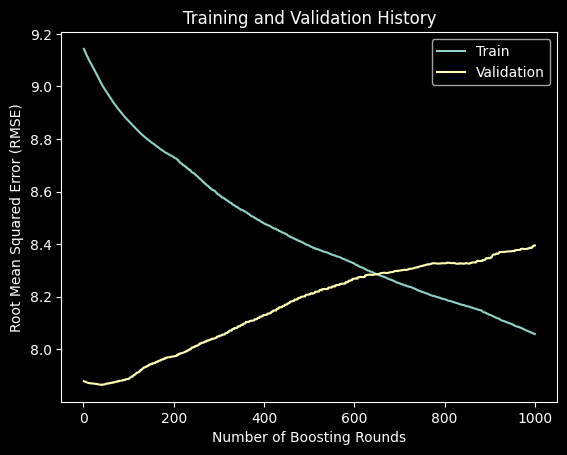

In [84]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

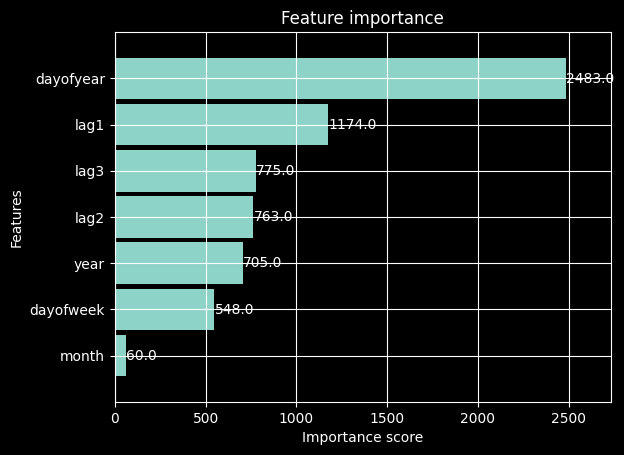

In [85]:
_ = plot_importance(reg, height=0.9)

In [86]:
y_pred = reg.predict(X_val)

In [87]:
val['prediction'] = reg.predict(X_val)

/tmp/ipython-input-1799221841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


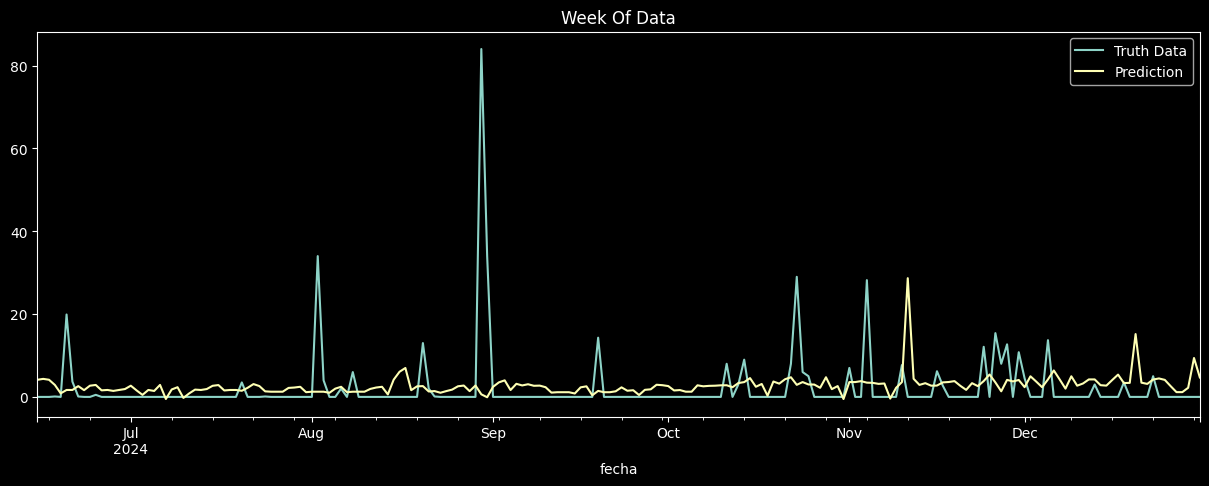

In [88]:
ax = val.loc[(val.index >= '2017-08-03')]['(mm)'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [89]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [90]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 70.47458999701631
Mean Absolute Error (MAE): 3.9788794875442983
RMSE Score on Test set: 8.39


[I 2025-10-08 15:44:36,201] A new study created in memory with name: no-name-600c94f8-757d-4ab7-9dff-7d780c2094cd
[I 2025-10-08 15:44:47,334] Trial 0 finished with value: 10.461221126957314 and parameters: {'n_estimators': 194, 'max_depth': 6, 'learning_rate': 0.05130071620568614, 'subsample': 0.7270664154417412, 'colsample_bytree': 0.785085462810337, 'reg_alpha': 3.0181124003658935e-08, 'reg_lambda': 0.0001548401962146741}. Best is trial 0 with value: 10.461221126957314.
[I 2025-10-08 15:44:49,083] Trial 1 finished with value: 9.707537019194415 and parameters: {'n_estimators': 168, 'max_depth': 3, 'learning_rate': 0.08802158907388465, 'subsample': 0.6221196658114145, 'colsample_bytree': 0.906919900312235, 'reg_alpha': 0.4888048399625844, 'reg_lambda': 2.4625192443852162e-08}. Best is trial 1 with value: 9.707537019194415.
[I 2025-10-08 15:44:56,559] Trial 2 finished with value: 9.84475057211871 and parameters: {'n_estimators': 480, 'max_depth': 7, 'learning_rate': 0.02847630974008659,

Best hyperparameters:  {'n_estimators': 343, 'max_depth': 5, 'learning_rate': 0.0013004264792132107, 'subsample': 0.6562517091774399, 'colsample_bytree': 0.7422133457451866, 'reg_alpha': 1.3416961229027979e-05, 'reg_lambda': 0.000698844636008547}
Best RMSE:  6.603830745219108


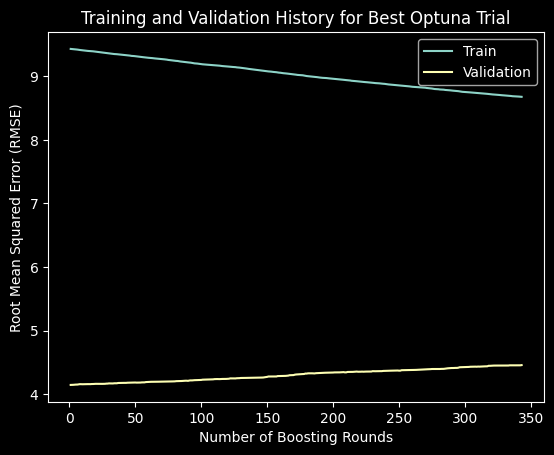

In [91]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
    rmse_scores = []

    df_processed = create_features(df_precipitaciones_cv.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] # Update feature names
    TARGET = '(mm)'

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

In [92]:
# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = '(mm)'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_precipitaciones_cv.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-07-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7422133457451866, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0013004264792132107,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=343, n_jobs=-1,
             num_parallel_tree=None, ...)

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 9.88
Final Model MAE on Test Set: 4.19


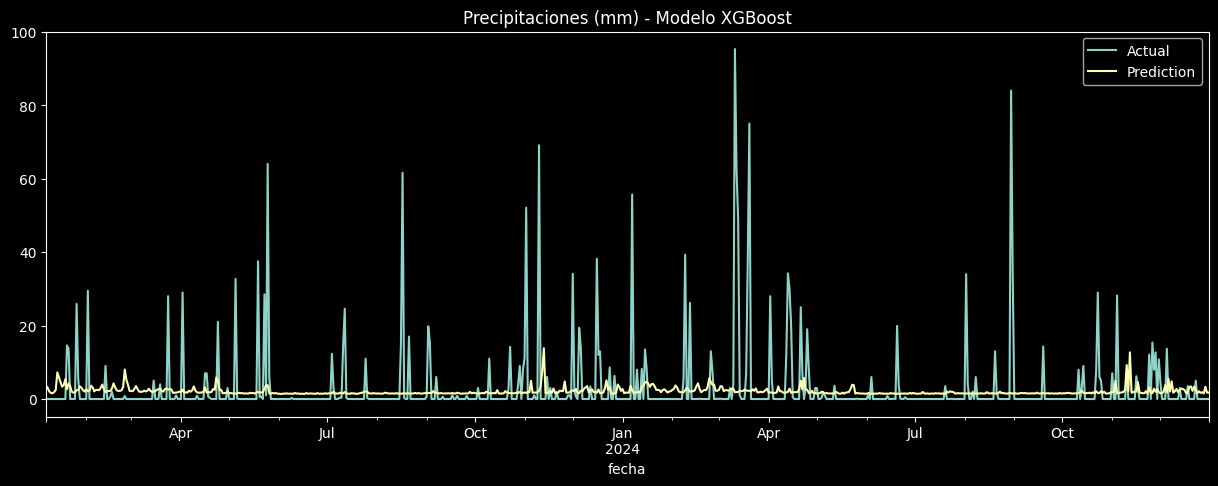

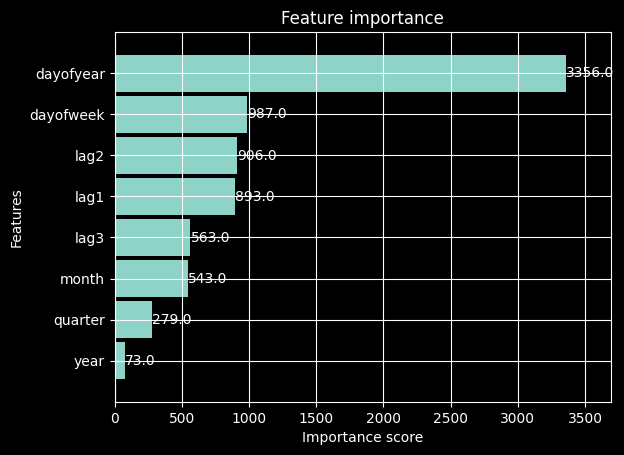

In [94]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Precipitaciones (mm) - Modelo XGBoost')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

In [95]:
import timesfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
contexto = 2000

model.compile(
    timesfm.ForecastConfig(
        max_context=contexto,      #<----esto se puede modificar
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True, # Importante para siniestros, que no pueden ser negativos
        fix_quantile_crossing=True,
    )
)

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [97]:
# 3. Preparación de tus datos
HORIZON = 30 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_precipitaciones_TFM = df_precipitaciones.copy()
split_index = int(len(data_precipitaciones_TFM) * 0.8)
train_precipitaciones_TFM = data_precipitaciones_TFM[:split_index]
test_precipitaciones_TFM = data_precipitaciones_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_precipitaciones_TFM['(mm)'][(contexto *-1):].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1753)


In [98]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_precipitaciones = point_forecast[0]

print(f"Se generaron {len(prediccion_precipitaciones)} predicciones para los próximos {HORIZON} días.")

Se generaron 30 predicciones para los próximos 30 días.


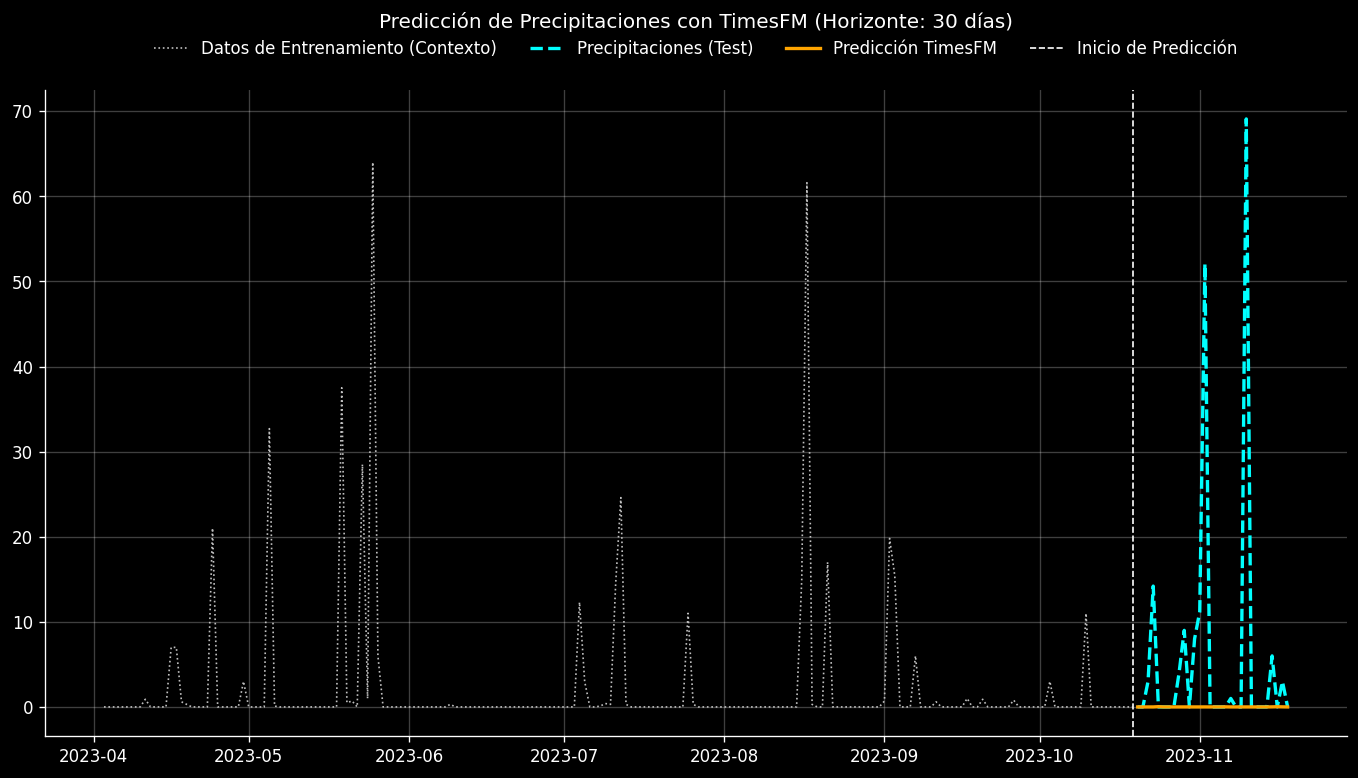

In [99]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_precipitaciones_TFM['(mm)'].iloc[:HORIZON].values,
    'Predichos': prediccion_precipitaciones
}, index=test_precipitaciones_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_precipitaciones_TFM.index[-200:], train_precipitaciones_TFM['(mm)'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Precipitaciones (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_precipitaciones_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Precipitaciones con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Times_FM2

Forma de los datos de entrada de Temperatura: (4, 1095)


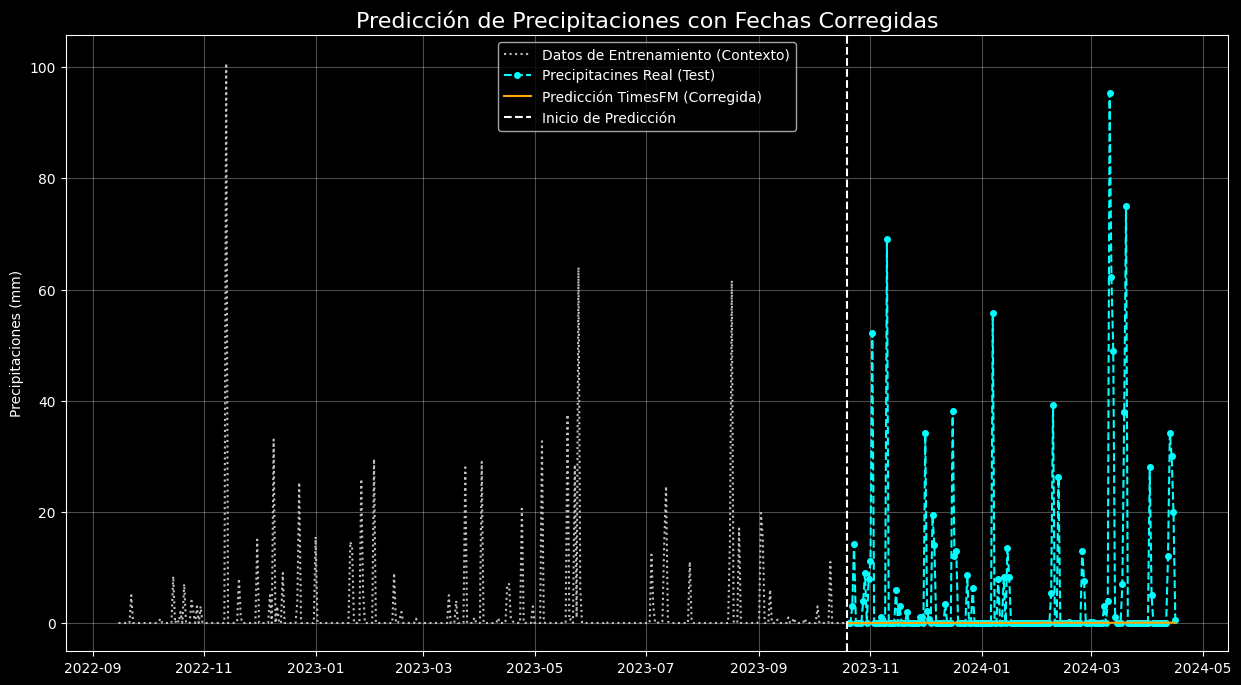

In [100]:
from sklearn.preprocessing import StandardScaler

# --- 1. FEATURE ENGINEERING (Esto ya estaba correcto) ---
df_precipitaciones_featured = df_precipitaciones.copy()
day_of_year = df_precipitaciones_featured.index.dayofyear
df_precipitaciones_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_precipitaciones_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
df_precipitaciones_featured['dayofweek'] = df_precipitaciones_featured.index.dayofweek

TARGET_COLUMN_TEMP = '(mm)'
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']
HORIZON_TEMP = 180 # Set the prediction horizon to 180 days
CONTEXT_WINDOW_TEMP = 1095

# --- 2. DIVISIÓN Y ESCALADO CORRECTOS (¡AQUÍ ESTÁ EL CAMBIO!) ---

# **PASO 2.1: PRIMERO, dividimos los datos**
split_index_temp = int(len(df_precipitaciones_featured) * 0.8)
train_data_temp = df_precipitaciones_featured[:split_index_temp].copy() # Usamos .copy() para evitar warnings
test_data_temp = df_precipitaciones_featured[split_index_temp:].copy()

# **PASO 2.2: LUEGO, creamos y AJUSTAMOS el escalador SOLO CON DATOS DE ENTRENAMIENTO**
scaler_temp = StandardScaler()
scaler_temp.fit(train_data_temp[FEATURES_TEMP])

# **PASO 2.3: AHORA, transformamos ambos conjuntos de datos por separado**
train_data_temp[FEATURES_TEMP] = scaler_temp.transform(train_data_temp[FEATURES_TEMP])
test_data_temp[FEATURES_TEMP] = scaler_temp.transform(test_data_temp[FEATURES_TEMP])

# --- 3. PREPARACIÓN DEL INPUT (Sin cambios, pero ahora usa datos bien escalados) ---
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN Y PREDICCIÓN (Sin cambios) ---
model.compile(
    timesfm.ForecastConfig(
        max_context=1024, max_horizon=512, normalize_inputs=True,
        use_continuous_quantile_head=True, force_flip_invariance=True,
        infer_is_positive=False, fix_quantile_crossing=True,
    )
)
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP, inputs=model_inputs_temp # Use HORIZON_TEMP for the prediction horizon
)

# --- CORRECCIÓN CLAVE: Construcción robusta del DataFrame de resultados ---

# 1. Obtenemos el índice de fechas exacto para el período de la predicción.
prediction_index = test_data_temp.index[:HORIZON_TEMP]

# 2. Get the unscaled predicted values
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
predicted_scaled[:, 0] = point_forecast_temp[0]
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)
predicted_values_temp = predicted_unscaled[:, 0]

# 3. Obtenemos los valores reales correspondientes a ESE índice desde el DataFrame ORIGINAL (no escalado).
real_values = df_precipitaciones.loc[prediction_index, TARGET_COLUMN_TEMP]

# 4. Creamos el DataFrame de resultados asegurando que todo esté alineado.
df_results_temp = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values_temp
}, index=prediction_index)


# --- Gráfico Corregido ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))

# Datos de entrenamiento (contexto) - tomados del df original para claridad
ax.plot(df_precipitaciones[TARGET_COLUMN_TEMP].loc[train_data_temp.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')

# Datos de prueba (reales) y la predicción - tomados del nuevo df_results_temp
ax.plot(df_results_temp.index, df_results_temp['Reales'], label='Precipitacines Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp.index, df_results_temp['Predichos'], label='Predicción TimesFM (Corregida)', color='orange', ls='-')

# Línea vertical de inicio de predicción
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.set_title('Predicción de Precipitaciones con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Precipitaciones (mm)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Chronos

In [101]:
df_modelo_precipitaciones_chronos = df_precipitaciones.copy()
## Parametros de prediccion
step_to_predict= 20  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider= 5 # Simula 5 futuros posibles para entender mejor lo que puede pasar

In [102]:
## Proyeccion
forecast = pipeline.predict(
    context=torch.tensor(df_modelo_precipitaciones_chronos["(mm)"]),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = range(len(df_modelo_precipitaciones_chronos), len(df_modelo_precipitaciones_chronos) + step_to_predict)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

/tmp/ipython-input-244631403.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df_modelo_precipitaciones_chronos["(mm)"]),


In [103]:
predicted_mean = forecast.mean(axis=0)
print(predicted_mean)

tensor([[4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 3.0042e+00, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 9.4621e-02, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08],
        [4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.8398e+01, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08],
        [4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08],
        [4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 3.0042e+00, 4.5075e-08, 4.5075e-08, 4.5075e-08,
       

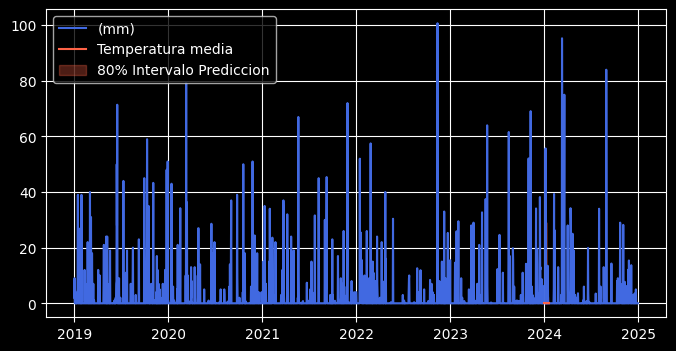

In [104]:
# Grafico
plt.figure(figsize=(8, 4))
plt.plot(df_modelo_precipitaciones_chronos["(mm)"], color="royalblue", label="(mm)")
# Modified: Plot the median prediction starting from the end of the historical data index
plt.plot(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), median, color="tomato", label="Temperatura media")
plt.fill_between(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), low, high, color="tomato", alpha=0.3, label="80% Intervalo Prediccion")
plt.legend()
plt.grid()
plt.show()

## Chronos_2

In [148]:
n_test = 20
df_precipitacines_chronos_train = df_modelo_precipitaciones_chronos[:-n_test]
df_precipitaciones_chronos_test = df_modelo_precipitaciones_chronos[-n_test:]

In [149]:
fechas_train = df_precipitacines_chronos_train.index
fechas_test = df_precipitaciones_chronos_test.index

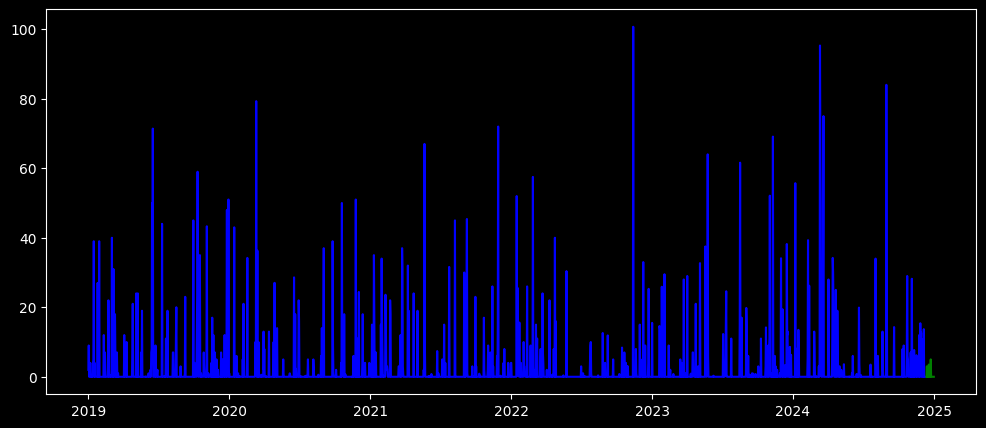

In [150]:
plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_precipitacines_chronos_train["(mm)"], label="Entrenamiento", color="blue")
plt.plot(fechas_test, df_precipitaciones_chronos_test["(mm)"], label="Test real", color="green")

In [151]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [152]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_siniestros_chronos_train["cantidad_eventos"]),
    prediction_length=n_test,
    quantile_levels=[0.1, 0.5, 0.9],
)

'''
El codigo nos da =
quantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.
quantiles[0.5] = idem pero para la mediana.
quantiles[0.9]= para el cuantil 90%.
mean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.
'''

/tmp/ipython-input-3408669728.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df_siniestros_chronos_train["cantidad_eventos"]),


'\nEl codigo nos da =\nquantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.\nquantiles[0.5] = idem pero para la mediana.\nquantiles[0.9]= para el cuantil 90%.\nmean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.\n'

In [153]:
# Aca imprime la ayuda del metodo
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

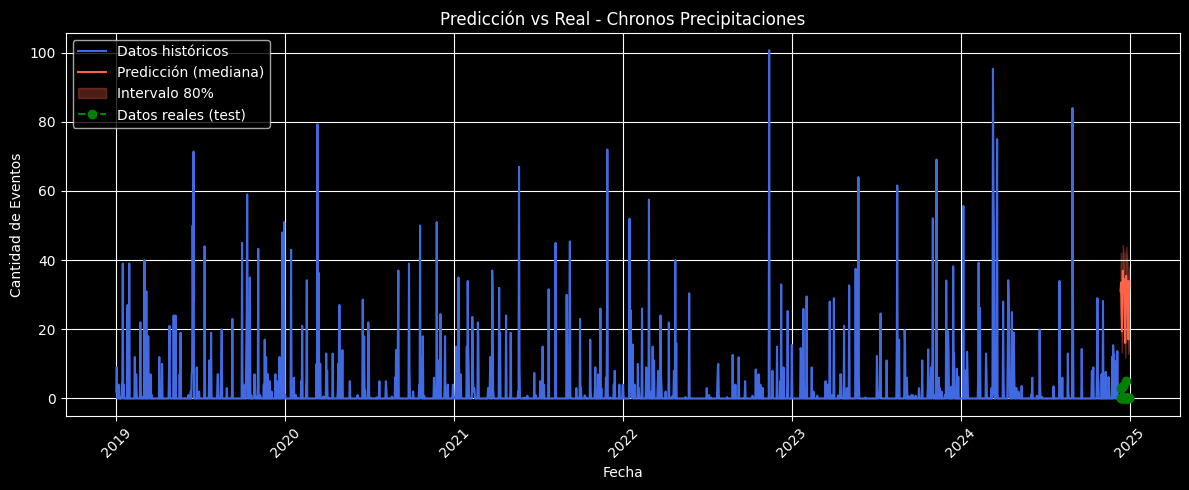

In [154]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np # Import numpy

# Extract quantiles and median from the prediction results
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Get the actual values from the test set
actual = df_precipitaciones_chronos_test["(mm)"].values

# Get the last date from the training set index
last_train_date = fechas_train[-1]

# Create a date range for the forecast starting from the day after the last training date
# The length of the forecast dates should match the length of the median prediction
forecast_dates = [last_train_date + timedelta(days=i) for i in range(1, len(median) + 1)]


plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_precipitacines_chronos_train["(mm)"], color="royalblue", label="Datos históricos")
plt.plot(forecast_dates, median, color="tomato", label="Predicción (mediana)")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="Intervalo 80%")
plt.plot(fechas_test, actual, color="green", linestyle="--", marker="o", label="Datos reales (test)")

plt.legend()
plt.grid()
plt.title("Predicción vs Real - Chronos Precipitaciones")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [155]:
import numpy as np

# Calculate RMSE for Chronos
rmse_chronos = np.sqrt(mean_squared_error(actual, median))

# Calculate MAE for Chronos
mae_chronos = mean_absolute_error(actual, median)

print(f"Chronos Model RMSE on Test Set: {rmse_chronos:0.2f}")
print(f"Chronos Model MAE on Test Set: {mae_chronos:0.2f}")

Chronos Model RMSE on Test Set: 28.95
Chronos Model MAE on Test Set: 28.31


# Temperatura

In [105]:
df_temperatura.rename(columns={'Unnamed: 0': 'fecha', '(°C)': 'Maxima', 'Unnamed: 2': 'Minima'}, inplace=True)
df_temperatura.head()

fecha Maxima Minima
0 2019-01-01   32.7   23.4
1 2019-01-02   32.1   23.7
2 2019-01-03   26.3     17
3 2019-01-04   28.9     18
4 2019-01-05   30.1   21.2

In [106]:
mask = (df_temperatura['Maxima'].isin(['\\N', 'N'])) | (df_temperatura['Minima'].isin(['\\N', 'N']))

In [107]:
# 1. Reemplazar '\\N' (y posiblemente 'N') por NaN
df_temperatura[['Maxima', 'Minima']] = df_temperatura[['Maxima', 'Minima']].replace({'\\N': np.nan, 'N': np.nan})

# 2. Convertir a float
df_temperatura[['Maxima', 'Minima']] = df_temperatura[['Maxima', 'Minima']].astype(float)

# 3. Verificar los tipos
print(df_temperatura.dtypes)
print(df_temperatura.isna().sum())
df_temperatura.dropna(inplace=True)
print(df_temperatura.isna().sum())
print(df_temperatura.dtypes)


fecha     datetime64[ns]
Maxima           float64
Minima           float64
dtype: object
fecha     0
Maxima    1
Minima    1
dtype: int64
fecha     0
Maxima    0
Minima    0
dtype: int64
fecha     datetime64[ns]
Maxima           float64
Minima           float64
dtype: object


In [108]:
df_temperatura['Media']= (df_temperatura['Maxima'] + df_temperatura['Minima']) / 2

In [109]:
df_temperatura.set_index('fecha', inplace=True)

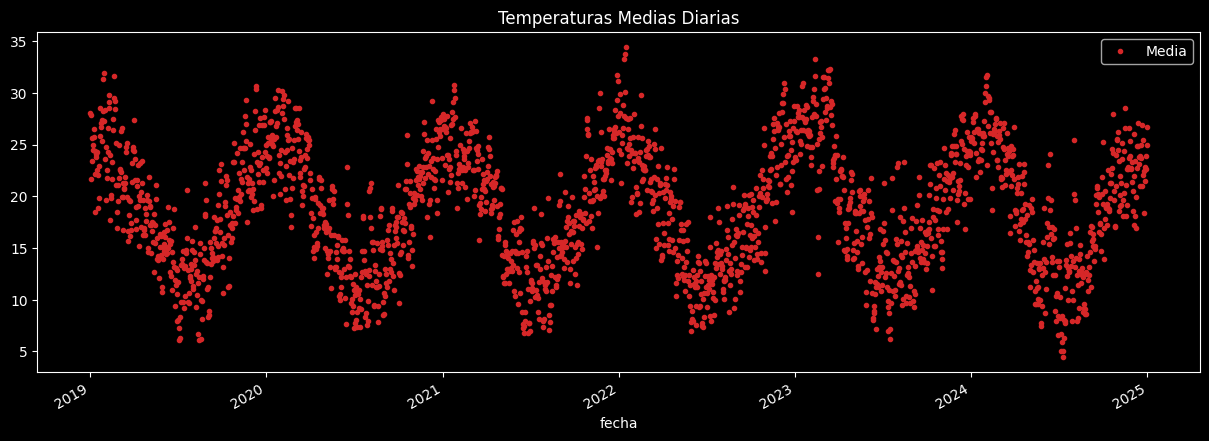

In [110]:
# Seleccionar la temperatura media como nuestro objetivo a predecir
df_modelo_temp = df_temperatura[['Media']].copy()

# Visualización de la nueva serie temporal de temperatura media
df_modelo_temp.plot(style='.',
                    figsize=(15, 5),
                    color=color_pal[3],
                    title='Temperaturas Medias Diarias')
plt.show()

In [111]:
def create_features(df):
    """
    Crea características temporales a partir del índice de tipo datetime de un DataFrame.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_modelo_temp = create_features(df_modelo_temp)

In [112]:
# Usamos TimeSeriesSplit para la validación cruzada
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)

scores = []
fold = 0
for train_idx, val_idx in tss.split(df_modelo_temp):
    train = df_modelo_temp.iloc[train_idx]
    test = df_modelo_temp.iloc[val_idx]

    # ¡IMPORTANTE! Se define la variable 'Media' como objetivo
    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
    TARGET = 'Media'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False) # Se cambia a False para no imprimir el log de cada fold

    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print(f'Fold {fold} RMSE: {score}')
    fold += 1

print(f'\nPromedio de RMSE en todos los folds: {np.mean(scores):.4f}')


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:46:34] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 0 RMSE: 3.29685867653691


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:46:34] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 1 RMSE: 3.1779646497276786


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:46:34] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 2 RMSE: 3.295461221320478


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:46:35] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 3 RMSE: 3.9115707870891017


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:46:35] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


Fold 4 RMSE: 3.4202078820940183

Promedio de RMSE en todos los folds: 3.4204


[0]	validation_0-rmse:18.79457	validation_1-rmse:19.41684
[100]	validation_0-rmse:7.49566	validation_1-rmse:8.24098
[200]	validation_0-rmse:3.89277	validation_1-rmse:4.78093
[300]	validation_0-rmse:3.04320	validation_1-rmse:3.93876


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [15:46:36] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[400]	validation_0-rmse:2.86577	validation_1-rmse:3.76344
[500]	validation_0-rmse:2.80160	validation_1-rmse:3.73630
[528]	validation_0-rmse:2.78935	validation_1-rmse:3.73904


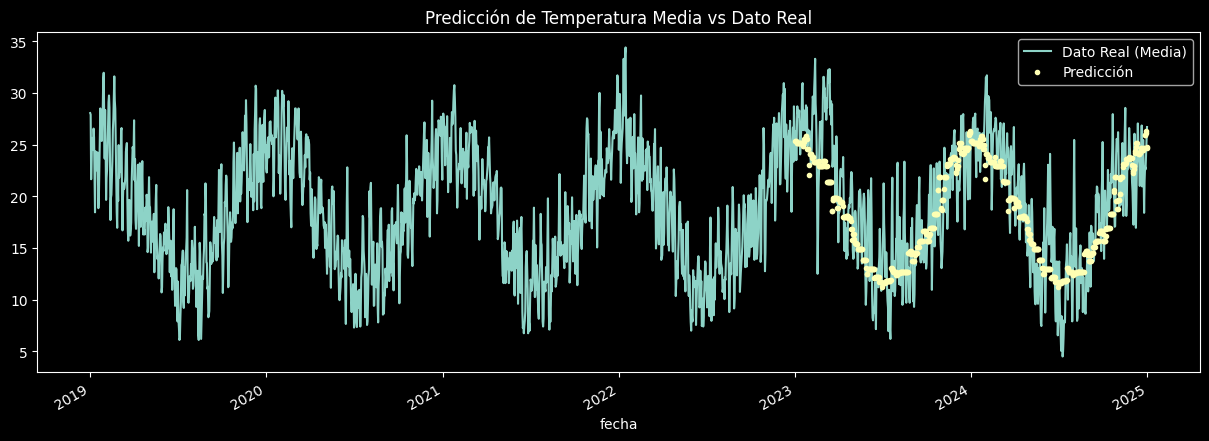

RMSE en el conjunto de prueba final: 3.7337


In [113]:
# Dividimos en conjunto de entrenamiento y prueba para el modelo final
split_date = '01-Jan-2023'
train = df_modelo_temp.loc[df_modelo_temp.index <= split_date].copy()
test = df_modelo_temp.loc[df_modelo_temp.index > split_date].copy()

# Entrenamos el modelo final con todos los datos de entrenamiento
X_train_final = train[FEATURES]
y_train_final = train[TARGET]
X_test_final = test[FEATURES]
y_test_final = test[TARGET]

reg_final = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg_final.fit(X_train_final, y_train_final,
        eval_set=[(X_train_final, y_train_final), (X_test_final, y_test_final)],
        verbose=100)

# Realizamos la predicción en el conjunto de prueba
test['prediction'] = reg_final.predict(X_test_final)
df_final = df_modelo_temp.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Visualización de la predicción vs los datos reales
ax = df_final[['Media']].plot(figsize=(15, 5))
df_final['prediction'].plot(ax=ax, style='.')
plt.legend(['Dato Real (Media)', 'Predicción'])
ax.set_title('Predicción de Temperatura Media vs Dato Real')
plt.show()

# Calculamos el error final
score_final = np.sqrt(mean_squared_error(test['Media'], test['prediction']))
print(f'RMSE en el conjunto de prueba final: {score_final:.4f}')

[I 2025-10-08 15:46:40,443] A new study created in memory with name: no-name-5d6b9fe1-d83a-4fe0-8242-c0e031242833
[I 2025-10-08 15:46:49,492] Trial 0 finished with value: 5.845958796192987 and parameters: {'n_estimators': 816, 'max_depth': 7, 'learning_rate': 0.03550218443386938, 'subsample': 0.8920359028672884, 'colsample_bytree': 0.9595706323110104, 'reg_alpha': 0.0008425834597256952, 'reg_lambda': 1.5356395203562715e-06}. Best is trial 0 with value: 5.845958796192987.
[I 2025-10-08 15:46:54,488] Trial 1 finished with value: 5.712510382904375 and parameters: {'n_estimators': 974, 'max_depth': 8, 'learning_rate': 0.08285513528944348, 'subsample': 0.9332560901663456, 'colsample_bytree': 0.8816913695447041, 'reg_alpha': 0.15909456876006536, 'reg_lambda': 0.5285504867522699}. Best is trial 1 with value: 5.712510382904375.
[I 2025-10-08 15:47:01,234] Trial 2 finished with value: 5.681778882386011 and parameters: {'n_estimators': 630, 'max_depth': 10, 'learning_rate': 0.07674555977022046, 

Best hyperparameters:  {'n_estimators': 630, 'max_depth': 10, 'learning_rate': 0.07674555977022046, 'subsample': 0.8829485645730788, 'colsample_bytree': 0.7455065784805066, 'reg_alpha': 0.3671784058893221, 'reg_lambda': 0.00043185534084681223}
Best RMSE:  5.681778882386011


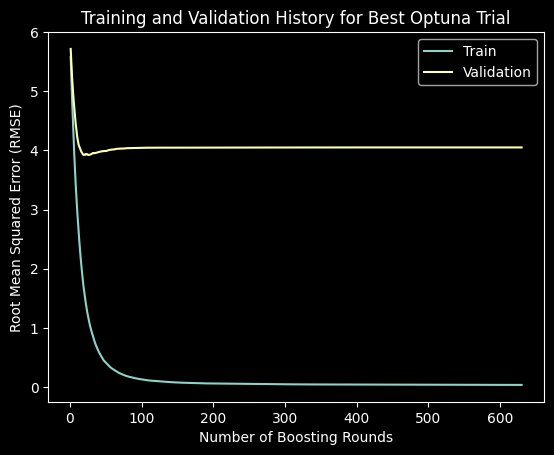

In [114]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

# Modify the add_lags function to work with the 'Media' column
def add_lags(df):
    """
    Add lag features to the DataFrame based on the 'Media' column.
    """
    # Check if 'Media' column exists before proceeding
    if 'Media' not in df.columns:
        print("Error: 'Media' column not found in the DataFrame.")
        return df # Return the original DataFrame if the column is missing

    target_map = df['Media'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df


def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    df_processed = create_features(df_modelo_temp.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

    # Calculate compatible test_size for TimeSeriesSplit
    n_samples = len(df_processed)
    n_splits = 5
    gap = 1
    # test_size = int((n_samples - gap) / (n_splits + 1)) -1 # This is one way to calculate test_size
    test_size = 218 # Adjusted test_size to be compatible with the number of samples

    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    rmse_scores = []


    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                'lag1','lag2','lag3'] # Include lag features
    TARGET = 'Media' # Set target to 'Media' for temperature data

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

In [115]:
# Define features and target
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                'lag1','lag2','lag3']
TARGET = 'Media'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_modelo_temp.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-01-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7455065784805066, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07674555977022046,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=630, n_jobs=-1,
             num_parallel_tree=None, ...)

In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 4.06
Final Model MAE on Test Set: 3.24


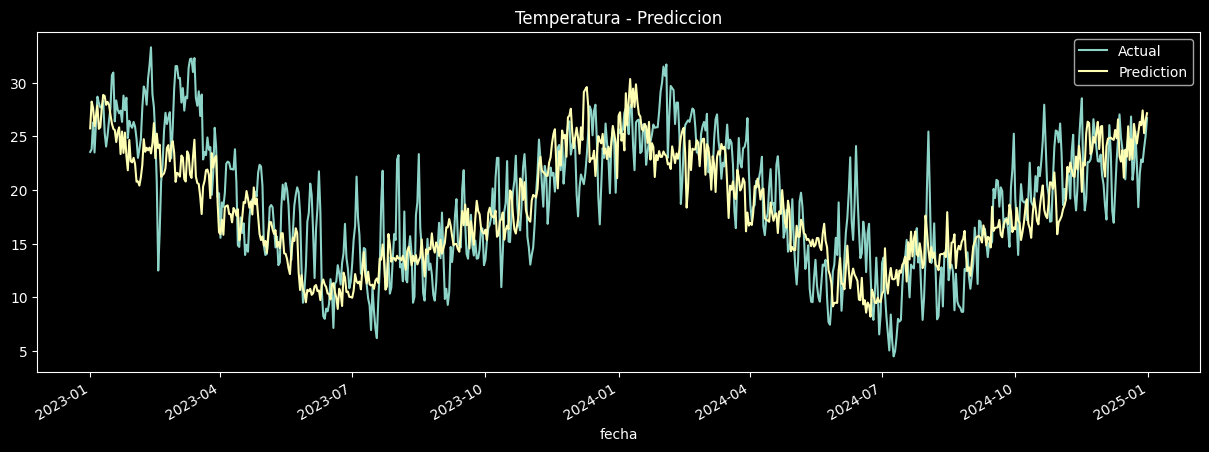

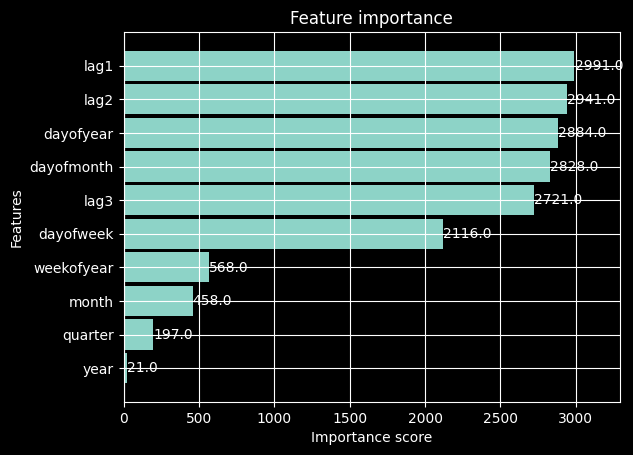

In [117]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Temperatura - Prediccion')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

In [118]:
# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,    ## <- Aqui modifico la ventana, hay que probar diferentes variantes
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=False,
        fix_quantile_crossing=True,
    )
)

In [119]:
# 3. Preparación de tus datos
HORIZON = 15 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_temperatura_TFM = df_modelo_temp.copy()
split_index = int(len(data_temperatura_TFM) * 0.8)
train_temperatura_TFM = data_temperatura_TFM[:split_index]
test_temperatura_TFM = data_temperatura_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_temperatura_TFM['Media'][-1024:].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1024)


In [120]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_temperatura = point_forecast[0]

print(f"Se generaron {len(prediccion_temperatura)} predicciones para los próximos {HORIZON} días.")

Se generaron 15 predicciones para los próximos 15 días.


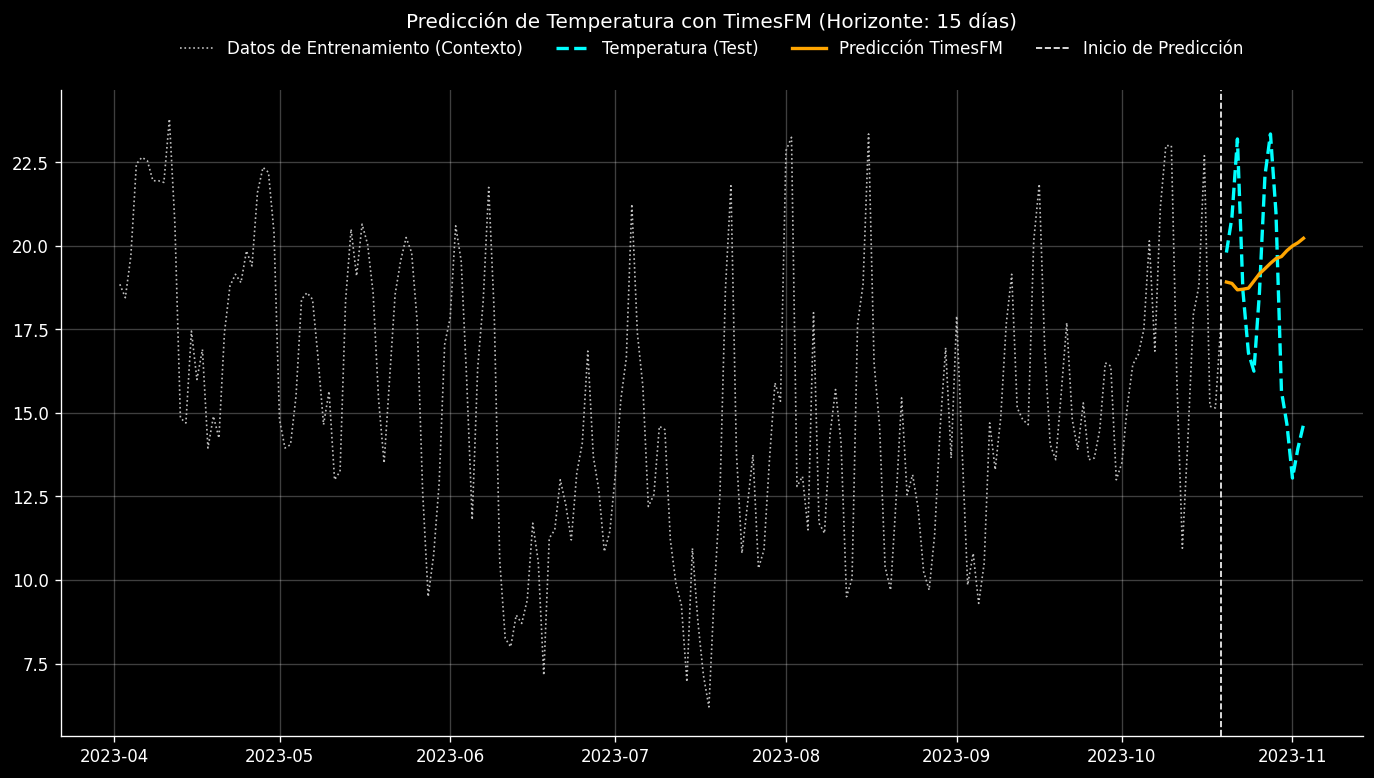

In [121]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_temperatura_TFM['Media'].iloc[:HORIZON].values,
    'Predichos': prediccion_temperatura
}, index=test_temperatura_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_temperatura_TFM.index[-200:], train_temperatura_TFM['Media'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Temperatura (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_temperatura_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Temperatura con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## TimesFM_2

Forma de los datos de entrada de Temperatura: (4, 730)


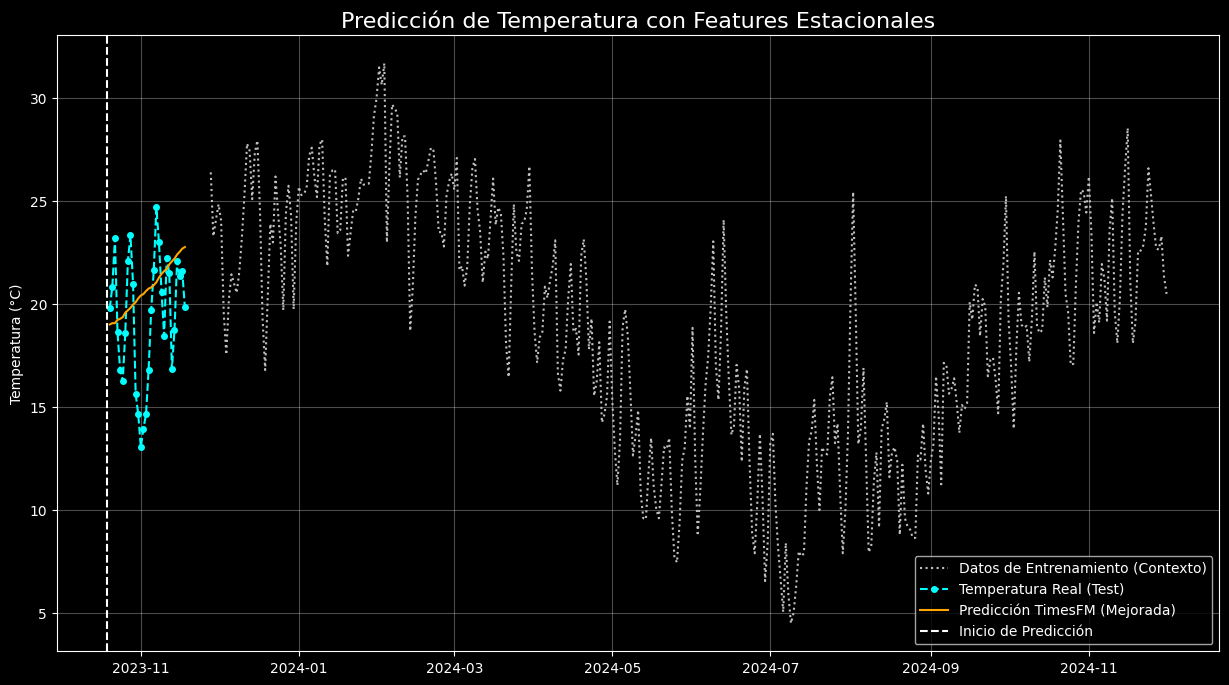

In [122]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Hacemos una copia para no modificar el dataframe original
df_temp_featured = df_modelo_temp.copy()

# La característica más importante para la temperatura es el ciclo anual.
# Usamos el día del año y lo transformamos con seno y coseno
# para que el modelo entienda que el día 365 está cerca del día 1.
day_of_year = df_temp_featured.index.dayofyear
df_temp_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

# También añadimos el día de la semana, que puede capturar patrones semanales
df_temp_featured['dayofweek'] = df_temp_featured.index.dayofweek

# --- 2. ESCALADO DE TODAS LAS CARACTERÍSTICAS ---

# Definimos la columna objetivo y las características que usaremos
TARGET_COLUMN_TEMP = 'Media'
# Nota: La columna objetivo también se escala junto con las demás.
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']

# Creamos y ajustamos el escalador a todas las características
scaler_temp = StandardScaler()
df_temp_featured[FEATURES_TEMP] = scaler_temp.fit_transform(df_temp_featured[FEATURES_TEMP])

# --- 3. DIVISIÓN DE DATOS Y PREPARACIÓN DEL INPUT ---
HORIZON_TEMP = 30
CONTEXT_WINDOW_TEMP = 730 # Un año de contexto es ideal para capturar la estacionalidad anual

split_index_temp = int(len(df_temp_featured) * 0.8)
train_data_temp = df_temp_featured[:split_index_temp]
test_data_temp = df_temp_featured[split_index_temp:]

# Extraer el contexto del final del set de entrenamiento
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()

# Transponer para obtener la forma correcta: (num_features, context_length)
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN DEL MODELO Y PREDICCIÓN ---

# Re-compilamos el modelo con la configuración correcta para temperatura
# La única diferencia es infer_is_positive=False
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=False, # ¡Importante! La temperatura puede ser negativa
        fix_quantile_crossing=True,
    )
)

# Realizar la predicción
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP,
    inputs=model_inputs_temp
)

# --- 5. RE-ESCALADO DE LOS RESULTADOS Y VISUALIZACIÓN ---

# El modelo predice valores escalados, ¡debemos revertir la transformación!
# Creamos un array vacío con la misma forma que los datos originales (N, 4 features)
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
# Ponemos la predicción en la primera columna (la de la variable objetivo)
predicted_scaled[:, 0] = point_forecast_temp[0]

# Usamos el método `inverse_transform` del scaler para obtener los valores en la escala original
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)

# La predicción en la escala original está en la primera columna
predicted_values_temp = predicted_unscaled[:, 0]

# También necesitamos los datos reales sin escalar para comparar
reales_unscaled = scaler_temp.inverse_transform(
    test_data_temp[FEATURES_TEMP].iloc[:HORIZON_TEMP]
)[:, 0]

# Crear DataFrame para graficar
df_results_temp = pd.DataFrame({
    'Reales': reales_unscaled,
    'Predichos': predicted_values_temp
}, index=test_data_temp.index[:HORIZON_TEMP])

# Graficar
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_modelo_temp['Media'][-400:-HORIZON_TEMP], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')
ax.plot(df_results_temp['Reales'], label='Temperatura Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp['Predichos'], label='Predicción TimesFM (Mejorada)', color='orange', ls='-')
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')
ax.set_title('Predicción de Temperatura con Features Estacionales', fontsize=16)
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


Forma de los datos de entrada de Temperatura: (4, 1095)


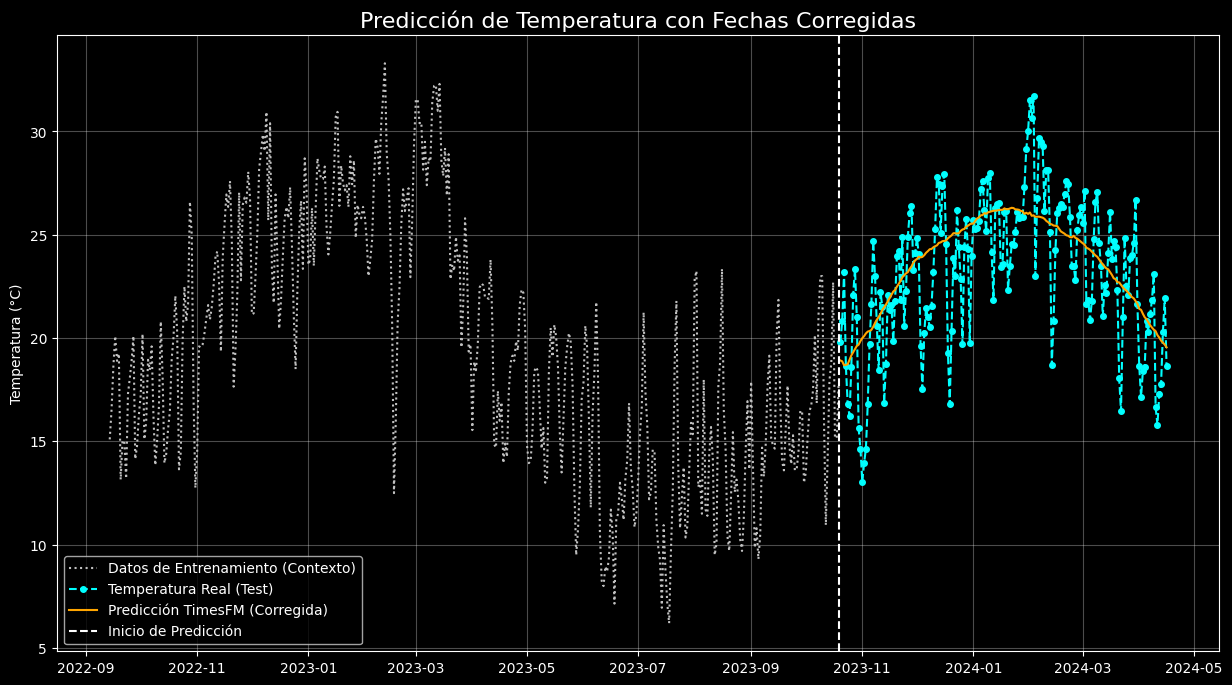

In [123]:
# --- 1. FEATURE ENGINEERING (Esto ya estaba correcto) ---
df_temp_featured = df_modelo_temp.copy()
day_of_year = df_temp_featured.index.dayofyear
df_temp_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofweek'] = df_temp_featured.index.dayofweek

TARGET_COLUMN_TEMP = 'Media'
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']
HORIZON_TEMP = 180 # Set the prediction horizon to 180 days
CONTEXT_WINDOW_TEMP = 1095

# --- 2. DIVISIÓN Y ESCALADO CORRECTOS (¡AQUÍ ESTÁ EL CAMBIO!) ---

# **PASO 2.1: PRIMERO, dividimos los datos**
split_index_temp = int(len(df_temp_featured) * 0.8)
train_data_temp = df_temp_featured[:split_index_temp].copy() # Usamos .copy() para evitar warnings
test_data_temp = df_temp_featured[split_index_temp:].copy()

# **PASO 2.2: LUEGO, creamos y AJUSTAMOS el escalador SOLO CON DATOS DE ENTRENAMIENTO**
scaler_temp = StandardScaler()
scaler_temp.fit(train_data_temp[FEATURES_TEMP])

# **PASO 2.3: AHORA, transformamos ambos conjuntos de datos por separado**
train_data_temp[FEATURES_TEMP] = scaler_temp.transform(train_data_temp[FEATURES_TEMP])
test_data_temp[FEATURES_TEMP] = scaler_temp.transform(test_data_temp[FEATURES_TEMP])

# --- 3. PREPARACIÓN DEL INPUT (Sin cambios, pero ahora usa datos bien escalados) ---
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN Y PREDICCIÓN (Sin cambios) ---
model.compile(
    timesfm.ForecastConfig(
        max_context=1024, max_horizon=512, normalize_inputs=True,
        use_continuous_quantile_head=True, force_flip_invariance=True,
        infer_is_positive=False, fix_quantile_crossing=True,
    )
)
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP, inputs=model_inputs_temp # Use HORIZON_TEMP for the prediction horizon
)

# --- CORRECCIÓN CLAVE: Construcción robusta del DataFrame de resultados ---

# 1. Obtenemos el índice de fechas exacto para el período de la predicción.
prediction_index = test_data_temp.index[:HORIZON_TEMP]

# 2. Get the unscaled predicted values
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
predicted_scaled[:, 0] = point_forecast_temp[0]
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)
predicted_values_temp = predicted_unscaled[:, 0]

# 3. Obtenemos los valores reales correspondientes a ESE índice desde el DataFrame ORIGINAL (no escalado).
real_values = df_modelo_temp.loc[prediction_index, TARGET_COLUMN_TEMP]

# 4. Creamos el DataFrame de resultados asegurando que todo esté alineado.
df_results_temp = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values_temp
}, index=prediction_index)


# --- Gráfico Corregido ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))

# Datos de entrenamiento (contexto) - tomados del df original para claridad
ax.plot(df_modelo_temp[TARGET_COLUMN_TEMP].loc[train_data_temp.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')

# Datos de prueba (reales) y la predicción - tomados del nuevo df_results_temp
ax.plot(df_results_temp.index, df_results_temp['Reales'], label='Temperatura Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp.index, df_results_temp['Predichos'], label='Predicción TimesFM (Corregida)', color='orange', ls='-')

# Línea vertical de inicio de predicción
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.set_title('Predicción de Temperatura con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Chronos

In [124]:
df_modelo_temp_chronos = df_modelo_temp.copy()
## Parametros de prediccion
step_to_predict= 45  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider= 2 # Simula 5 futuros posibles para entender mejor lo que puede pasar

In [125]:
## Proyeccion
forecast = pipeline.predict(
    context=torch.tensor(df_modelo_temp_chronos["Media"]),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = range(len(df_modelo_temp_chronos), len(df_modelo_temp_chronos) + step_to_predict)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

/tmp/ipython-input-285864261.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df_modelo_temp_chronos["Media"]),


In [126]:
predicted_mean = forecast.mean(axis=0)
print(predicted_mean)

tensor([[26.4211, 27.2468, 28.6229, 26.4211, 23.8065, 24.6322, 25.3203, 26.2835,
         26.6964, 27.1092, 28.7605, 25.8707, 22.7057, 22.4305, 23.3937, 24.0818,
         25.3203, 25.3203, 25.5955, 25.5955, 24.3570, 22.9809, 22.9809, 23.2561,
         21.8800, 25.1827, 25.8707, 26.1459, 27.5220, 27.3844, 26.9716, 24.4946,
         24.4946, 25.3203, 26.5588, 25.7331, 24.4946, 25.0450, 22.8433, 22.8433,
         23.5313, 23.2561, 22.7057, 23.5313, 23.8065],
        [26.5588, 26.8340, 24.7698, 25.0450, 26.5588, 26.2835, 24.9074, 24.0818,
         22.2928, 23.5313, 26.6964, 27.9349, 23.5313, 23.6689, 26.0083, 25.0450,
         24.7698, 23.9442, 26.0083, 26.1459, 28.4853, 26.2835, 23.1185, 21.6048,
         25.3203, 28.7605, 29.5862, 30.4118, 26.6964, 27.1092, 25.4579, 25.5955,
         22.7057, 21.6048, 23.6689, 26.4211, 25.5955, 26.6964, 28.2101, 28.0725,
         27.7972, 26.4211, 25.7331, 26.0083, 25.1827]])


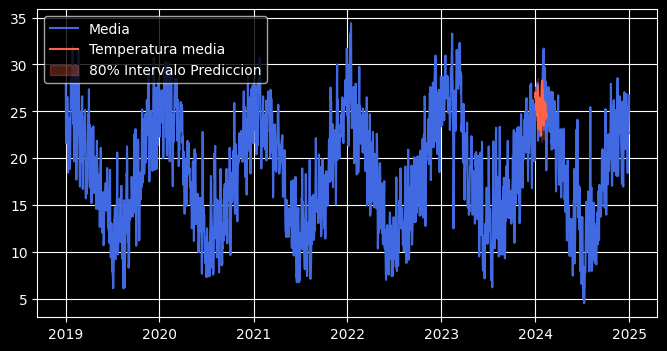

In [127]:
# Grafico
plt.figure(figsize=(8, 4))
plt.plot(df_modelo_temp_chronos["Media"], color="royalblue", label="Media")
# Modified: Plot the median prediction starting from the end of the historical data index
plt.plot(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), median, color="tomato", label="Temperatura media")
plt.fill_between(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), low, high, color="tomato", alpha=0.3, label="80% Intervalo Prediccion")
plt.legend()
plt.grid()
plt.show()

## Chronos_2

In [128]:
n_test = 25
df_temperatura_chronos_train = df_modelo_temp_chronos[:-n_test]
df_temperatura_chronos_test = df_modelo_temp_chronos [-n_test:]

In [129]:
df_siniestros_chronos_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2023-12-07 to 2023-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   cantidad_eventos  25 non-null     int64
dtypes: int64(1)
memory usage: 400.0 bytes


In [130]:
fechas_train = df_temperatura_chronos_train.index
fechas_test = df_temperatura_chronos_test.index

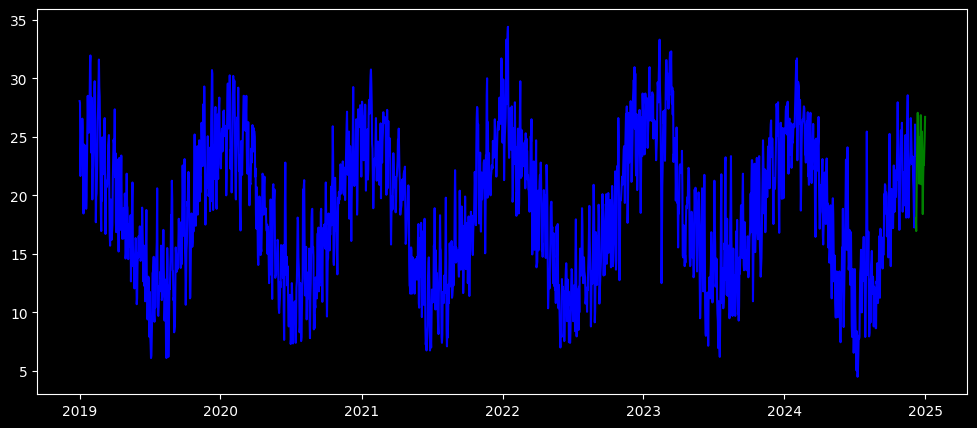

In [131]:
plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_temperatura_chronos_train["Media"], label="Entrenamiento", color="blue")
plt.plot(fechas_test, df_temperatura_chronos_test["Media"], label="Test real", color="green")

In [132]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [133]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_temperatura_chronos_train["Media"]),
    prediction_length=n_test,
    quantile_levels=[0.1, 0.5, 0.9],
)

'''
El codigo nos da =
quantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.
quantiles[0.5] = idem pero para la mediana.
quantiles[0.9]= para el cuantil 90%.
mean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.
'''

/tmp/ipython-input-1000776581.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df_temperatura_chronos_train["Media"]),


'\nEl codigo nos da =\nquantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.\nquantiles[0.5] = idem pero para la mediana.\nquantiles[0.9]= para el cuantil 90%.\nmean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.\n'

In [134]:
# Aca imprime la ayuda del metodo
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

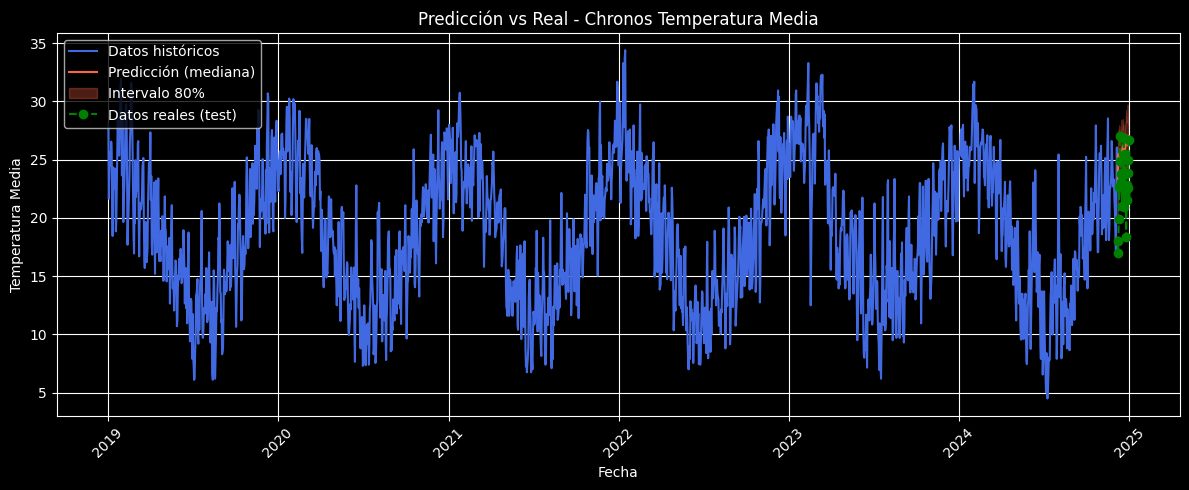

In [135]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np # Import numpy

# Extract quantiles and median from the prediction results
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Get the actual values from the test set
actual = df_temperatura_chronos_test["Media"].values

# Get the last date from the training set index
last_train_date = fechas_train[-1]

# Create a date range for the forecast starting from the day after the last training date
# The length of the forecast dates should match the length of the median prediction
forecast_dates = [last_train_date + timedelta(days=i) for i in range(1, len(median) + 1)]


plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_temperatura_chronos_train["Media"], color="royalblue", label="Datos históricos")
plt.plot(forecast_dates, median, color="tomato", label="Predicción (mediana)")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="Intervalo 80%")
plt.plot(fechas_test, actual, color="green", linestyle="--", marker="o", label="Datos reales (test)")

plt.legend()
plt.grid()
plt.title("Predicción vs Real - Chronos Temperatura Media")
plt.xlabel("Fecha")
plt.ylabel("Temperatura Media")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [136]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE for Chronos
rmse_chronos = np.sqrt(mean_squared_error(actual, median))

# Calculate MAE for Chronos
mae_chronos = mean_absolute_error(actual, median)

print(f"Chronos Model RMSE on Test Set: {rmse_chronos:0.2f}")
print(f"Chronos Model MAE on Test Set: {mae_chronos:0.2f}")

Chronos Model RMSE on Test Set: 3.84
Chronos Model MAE on Test Set: 3.07
